# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


All student names in group: Safwan Kader, Dylan Lai, Jerry Xiao

I understand that my submission needs to be my own group's work: SK, DL, JX

I understand that ChatGPT / Copilot / other AI tools are not allowed: SK, DL, JX

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

C:\Users\dilly\CSE352\HW1\CS7320-AI\Search


fatal: destination path 'CS7320-AI' already exists and is not an empty directory.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
#!git clone https://github.com/stanleybak/CS7320-AI.git

In [3]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [4]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

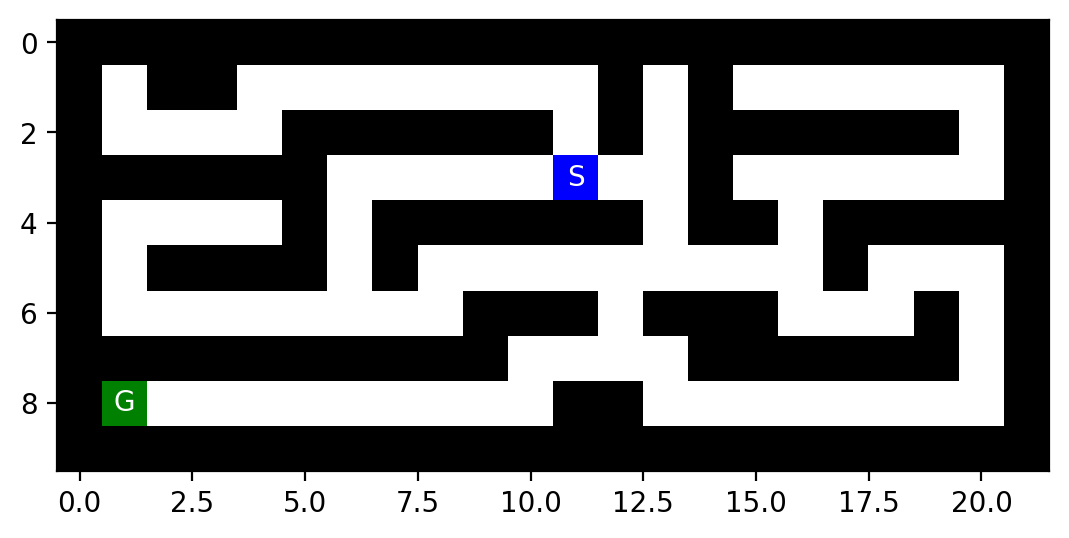

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [6]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [7]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    c:\users\dilly\cse352\hw1\cs7320-ai\search\maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [8]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def __lt__(self, other):
        return self.cost < other.cost

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](./CS3720-AI/Search/small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

- **Initial State (S₀):** 
  - The initial state **S** can be represented as a tuple in the set of all integers. It represents the starting position on the maze.

- **Actions (A):** 
  - The actions are the possible movements the agent can take in the maze, such as moving one step in any of the four directions (up, down, left, right). The actions will get passed to the transition model to determine possible states. In this case, the EXPAND function of a given node represents the possible actions/successors.

- **Transition Model (Result function):** 
  - The result function defines the outcome of taking a specific action in a given state. It determines the next state based on the current state and the action taken. The transition model takes in the current position of the agent and the action taken. Based on this, it outputs the new position of the agent after taking this action. These new states are pushed onto the frontier of each given problem and then further expanded to find the path to the goal. Each new state will be a tuple representing the new position of the agent. In this case, the transition model is used when a node is popped from the frontier. 
- **Goal State (G):** 
  - The goal state is the configuration of the maze where the agent has reached the destination. 

- **Path Cost (Cost function):** 
  - The cost function assigns a cost to each step or action in the maze, influencing the search algorithms to find the path with the lowest cumulative cost. These cost functions will be different depending on the search algorithms. For uninformed searches (BFS and DFS), the cost of each branch or path taken will just be 1. For greedy best-first search and A* search, the cost functions are adjusted to account for the given heuristic.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determine these values for a given maze.

- **State Space Size ($n$):** 
  - Count the number of cells or squares in the maze. Based on the mazes available, we can estimate state space sizes from 100 spaces to 1225 spaces. 

- **Depth of Optimal Solution ($d$):** 
  - Find the shortest path from the start to the goal in the maze. In order to find this, we'll need to use algorithms that prioritize optimal solutions such as breadth-first search or A* search. This can also very between different state space sizes.

- **Maximum Depth of Tree ($m$):** 
  - This can be determined by exploring the entire search tree until the goal is found. This favors algorithms like depth-first search which exhausts a singular path before finding a solution. Although not optimal, it will find the longest possible paths available in a given tree.

- **Maximum Branching Factor ($b$):** 
  - Count the maximum number of accessible neighboring cells for any given cell in the maze. The branching factor usually depends on the problem. In this case, it is almost certain that the maximum branching factor is four. This is because a given time, there are at most 4 possible directions the agent can take.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DFS can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DFS is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [9]:
from collections import deque 

# DFS Implementation

def dfs_maze_search(maze):
    """depth first search of the maze which returns the path, """
    root = Node(mh.find_pos(maze,what = 'S'), None, None, 0)
    goal_node = mh.find_pos(maze, what = 'G')
    
    
    if root.pos == goal_node:
        return {
            "solution" : root.get_path_from_root(),
            "total nodes" : 0,
            "max tree depth" : 0,
            "nodes in memory" : 1,
            "max frontier len" : 0,
        }
        
    # Total number of nodes expanded
    
    # Maximum tree depth
    
    # Maximum size of the frontier
    
    result = {
        "solution" : [],
        "total nodes" : 0,
        "max tree depth" : 0,
        "nodes in memory" : 1,
        "max frontier len" : 1
    }

    
    # initialize frontier stack
    frontier = [root]
    
    while frontier:
        # pop the last node
        cur_node = frontier.pop()
        
        if cur_node.pos == goal_node:
            result["solution"] = cur_node.get_path_from_root()
            return result
        
        children = get_surrounding_positions(maze,cur_node.pos)
        if children:
            result["total nodes"] += 1
        
        # get path from the root
        path = [node.pos for node in cur_node.get_path_from_root()]
        
        for child in children:
            if child not in path:
                
                # create a child node
                s = Node(child, cur_node, None, cur_node.cost + 1)
                result["nodes in memory"] += 1
                
                result["max tree depth"] = max(result["max tree depth"], s.cost)
                
                
                frontier.append(s)
                result["max frontier len"] = max(result["max frontier len"], len(frontier))
        
    return None

# BFS Implementation

def bfs_maze_search(maze):
    # use maze helper to get start position
    root = Node(mh.find_pos(maze,what = 'S'), None, None, 0)
    goal_node = mh.find_pos(maze, what = 'G')

    if root.pos == goal_node:
        return {
            "solution" : root.get_path_from_root(),
            "total nodes" : 0,
            "max tree depth" : 0,
            "nodes in memory" : 1,
            "max frontier length" : 0,
        }
    
    result = {
        "solution" : [],
        "total nodes" : 0,
        "max tree depth" : 0,
        "nodes in memory" : 1,
        "max frontier len" : 1
    }

    # initialize frontier queue and reached
    frontier = deque([root])
    reached = {root}

    while frontier:
        # pop from front of queue
        cur_node = frontier.popleft()
        # children are all surrounding nodes
        children = get_surrounding_positions(maze, cur_node.pos)
        result["total nodes"] += 1
        
        for child in children:
            # create a child node
            if child not in reached:
                
                s = Node(child, cur_node, None, cur_node.cost + 1)
                result["nodes in memory"] += 1
                
                result["max tree depth"] = max(result["max tree depth"], s.cost)
                # return if goal found
                if child == goal_node:
                    result["solution"] = s.get_path_from_root()
                    return result

                # add to reached and frontier otherwise
                reached.add(s.pos)
                frontier.append(s)
                result["max frontier len"] = max(result["max frontier len"], len(frontier))
    return None

def get_surrounding_positions(maze, position):
    x, y = position
    surrounding_positions = []

    if x >= 1 and maze[x - 1][y] != "X":
        surrounding_positions.append((x - 1, y))

    if y >= 1 and maze[x][y - 1] != "X":
        surrounding_positions.append((x, y - 1))

    if y + 1 < len(maze[0]) and maze[x][y + 1] != "X":
        surrounding_positions.append((x, y + 1))

    if x + 1 < len(maze) and maze[x + 1][y] != "X":
        surrounding_positions.append((x + 1, y))

    return surrounding_positions


How does BFS and DFS deal with loops (cycles)?

#### Breadth-First Search
- Breadth first search checks for cycles by maintaining a reached data structure. This reached data structure is a set that contains all of the nodes that have been previously visited. If a node has already been visited, BFS will skip this node and continue its search.

#### Depth-First Search
- Depth first does not have cycle detection since there is no reached data structure. This is very memory efficient in trees. However, for graphs such as this one, it will run infinitely since there is no way of checking whether a node has been visited previously. In order to combat this, we take advantage of the path of the nodes as the agent progresses the maze. If the current path contains a node that has already been visited, we skip and move to the others.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

#### **Breadth-First Search**
- Our Breadth first search algorithm is complete and optimal since breadth-first search exhausts all nodes at any given level of the graph. Given infinite time and memory, breadth-first search will always find a solution. It is also optimal since breadth-first search is checking all possible paths at each level. This means that the second the goal node is first encountered, it will be the shortest path. Both the time and space complexity of this algorithm is O(_b<sup>d</sup>_) where is _b_ is the branching factor and _d_ is the maximum depth.

*Space Complexity*
- Frontier Queue **O(_b<sup>d</sup>_)** : The maximum number of nodes in the queue at a given time will be some power of b (which can be up to 3) since each expansion will add at most _b_ nodes to the frontier. This power can be the shallowest depth (shortest path) to reach the solution.
- Reached Set **O(_b<sup>d</sup>_)** : The same memory of the frontier queue applies to the reached set since nodes are popped and placed in the reached set. The reached set will accumulate all of the popped nodes of the frontier hence making it the same space complexity.

*Time Complexity*
- Branching factor and Shallowest Depth **O(_b<sup>d</sup>_)** : Similar to the space complexity, we can traverse at most _b<sup>d</sup>_ since all of the nodes that will get created will either be expanded or skipped. The maximum branching factor is 3 since breadth first search maintains a reached set. This means it will never expand the node directly before it. The largest power we can reach is _d_ which is the shallowest depth to reach the solution.

#### Depth-First Search
- Our Depth-first search algorithm is neither complete or optimal. This is our because depth first will exhaust a single path before checking others and has a likely hood of encountering cycles if not handled carefully. It is also not optimal since depth first search only explores one possible path of the graph before trying others meaning that if multiple solutions exist, it will only give the first one found, not the most optimal. The space complexity of our depth first search algorithm is O(_b * m_) and the time complexity is O(_b<sup>m</sup>_).

*Space Complexity*
- Frontier Stack **O(_b * m_)** : The size of the frontier stack in memory is proportional to _ b * m_ or the branching factor times the maximum depth of the tree. This gives DFS an edge over BFS since its using memory that grows at a polynomial rather than exponentially.

*Time Complexity*
- Branching factor and Maximum Depth **O(_b<sup>m</sup>_)** : Since depth-first search doesn't make use of a reached set, it reduces memory overhead. However, the time complexity remains similar to breadth-first search in the worst case. In each iteration of the algorithm, we calculate the current path of the node which can take at most O(_m_) time. However, since this is being done for each branch of the tree, the time complexity ends up being O(_b<sup>m</sup>_). However, due to the nature of depth first search, if the goal node happens to be on the first path that is being searched, it can take significantly less time than in the worst case scenario. 


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [10]:
import heapq


def greedy_bestfs_maze_search(maze, heuristic):
    start_node = mh.find_pos(maze, what="S")
    goal_node = mh.find_pos(maze, what="G")
    
    root = Node(start_node, None, 0, 0)

    if root.pos == goal_node:
        return {
            "solution": root.get_path_from_root(),
            "total nodes": 0,
            "max tree depth": 0,
            "nodes in memory" : 1,
            "max frontier len": 0,
        }

    result = {
        "solution": [],
        "total nodes": 0,
        "max tree depth": 0,
        "nodes in memory" : 1,
        "max frontier len": 1,
    }

    frontier = [(heuristic(root.pos, goal_node),root)]
    reached = {mh.find_pos(maze, what="S"): root}

    while frontier:
        (_,cur_node) = heapq.heappop(frontier)

        children = get_surrounding_positions(maze, cur_node.pos)
        if children: 
            result["total nodes"] += 1
            
        for child in children:
            s = Node(child, cur_node, None, cur_node.cost + 1)
            result["max tree depth"] = max(s.cost, result["max tree depth"])
            
            # result["max tree depth"] = max(result["max tree depth"], s.cost)
            if child not in reached:
                result["nodes in memory"] += 1
                if child == goal_node:
                    result["solution"] = s.get_path_from_root()
                    return result

                reached[child] = s
                heapq.heappush(frontier, (heuristic(child, goal_node),s))
                result["max frontier len"] = max(result["max frontier len"], len(frontier))
        

    return None


# A* search implementation
def astar_maze_search(maze, heuristic):
    root = Node(mh.find_pos(maze, what="S"), None, None, 0)
    goal_node = mh.find_pos(maze, what="G")

    if root.pos == goal_node:
        return {
            "solution": root.get_path_from_root(),
            "total nodes": 0,
            "max tree depth": 0,
            "nodes in memory" : 1,
            "max frontier len": 0,
        }

    result = {
        "solution": [],
        "total nodes": 0,
        "max tree depth": 0,
        "nodes in memory" : 1,
        "max frontier len": 1,
    }

    # Use a tuple with the heuristic value as the first element and a tiebreaker as the second
    frontier = [(heuristic(root.pos, goal_node) + root.cost, root)]
    reached = {mh.find_pos(maze, what="S"): root}

    while frontier:
        (_, cur_node) = heapq.heappop(frontier)

        children = get_surrounding_positions(maze, cur_node.pos)
        if children: 
            result["total nodes"] += 1
            
        for child in children:
            s = Node(child, cur_node, None, cur_node.cost + 1)
            result["max tree depth"] = max(s.cost, result["max tree depth"])
            
            if child not in reached or heuristic(child, goal_node) + s.cost < heuristic(child, goal_node) + reached[child].cost:
                result["nodes in memory"] += 1
                if child == goal_node:
                    result["solution"] = s.get_path_from_root()
                    return result

                reached[child] = s
                heapq.heappush(frontier, (heuristic(child, goal_node) + s.cost, s))
                result["max frontier len"] = max(result["max frontier len"], len(frontier))
              
        
    return None


def manhattan_distance(node, goal):
    x1, y1 = node
    x2, y2 = goal
    return abs(x1 - x2) + abs(y1 - y2)

Are your implementations complete and optimal? What is the time and space complexity?

For these algorithms, it is important to consider two properties
- Admissibility : A heuristic is admissible if it never overestimates the cost to reach a goal
- Consistency : A heuristic is consistent if h(n) ≤ c(n,a,n′) +h(n′) where h(n) is the heuristic, n is any given node, n' is every successor of n, c is the cost, and a is the action.

#### Greedy Best-first search
- This greedy best-first search algorithm implementation is complete but not optimal. Although it will likely lead to more optimal answers than a simple depth-first search, greedy best-first search makes decision based on the most optimal decision locally. Since the path can vary, this can lead to frequent instances of a path that gets close to the goal without reaching it at the most optimal path. Greedy best-first search is complete since it holds a reached set to keep track of visited nodes and will not revisit nodes that may cause loops.

*Space Complexity*
- Frontier Priority Queue **O(_b<sup>d</sup>_)** : The priority queue will take up a similar amount of memory to breadth-first search since the number of nodes added to the queue will not be different. The main difference is which node gets popped first.
- Reached Set **O(_b<sup>d</sup>_)** : Again, we use a similar amount of memory in this reached set. This is because the reached set will explore all of the popped nodes in the tree. This number can potentially be smaller in cases where greedy best-first search finds an optimal solution quicker.

*Time Complexity*
- Branching factor and Shallowest Depth **O(_b<sup>d</sup>_)** : Greedy best-first search will have a time complexity that is proportional to the the branching factor and shallowest depth. The manhattan distance heuristic helps slightly. Due to the greedy nature of the algorithm, it will still traverse nodes at a complexity of _b<sup>d</sup>_ in the worst case.

#### A* Search
- The A* star search algorithm implementation is both complete and optimal. A* search is always guaranteed to find a solution since it is checking all possible paths. It is also optimal since the manhattan distance (both admissible and consistent) satisfies the triangle inequality which makes it a good heuristic for this algorithm.

*Space Complexity*
- Frontier Priority Queue **O(_b<sup>d</sup>_)** : The priority queue will take up a similar amount of memory to greedy best-first search since it is just evaluating the queue based on a slightly different measure.
- Reached Set **O(_b<sup>d</sup>_)** : Again, we use a similar amount of memory in this reached set. This is because the reached set will explore all of the popped nodes in the tree.

*Time Complexity*
- Branching factor and Shallowest Depth **O(_b<sup>d</sup>_)** : A* star search will have the same time complexity in the worst case since it still has a possibility of exploring all the nodes up to the shallowest depth. The only guarantee is that most optimal solution will be found.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.


 small_maze.txt 

Breadth-First search
Solution:


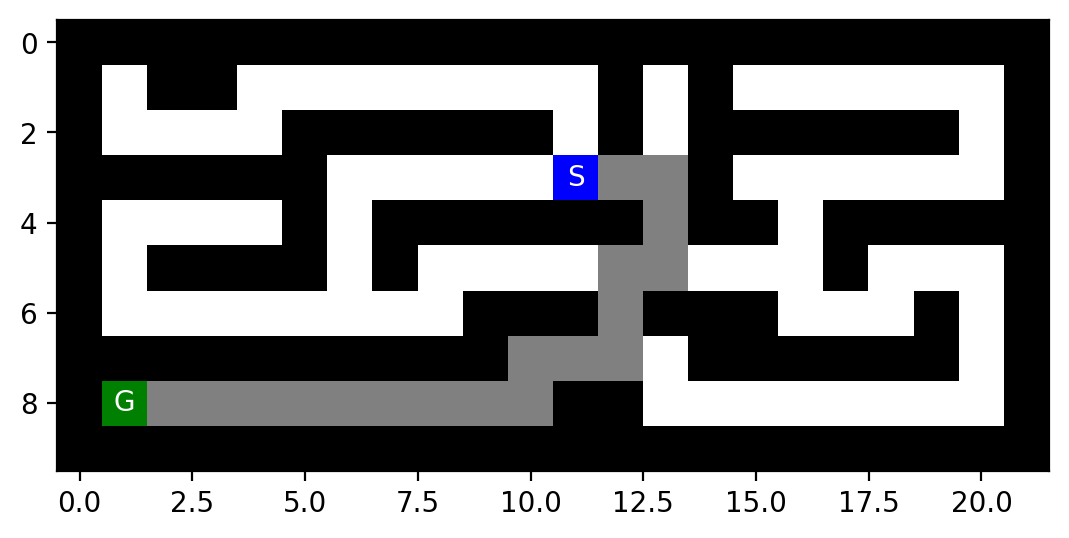

Total cost:  19
Total nodes expanded:  91
Max tree depth:  19
Total nodes in memory:  93
Max frontier size:  8

Depth-First search
Solution:


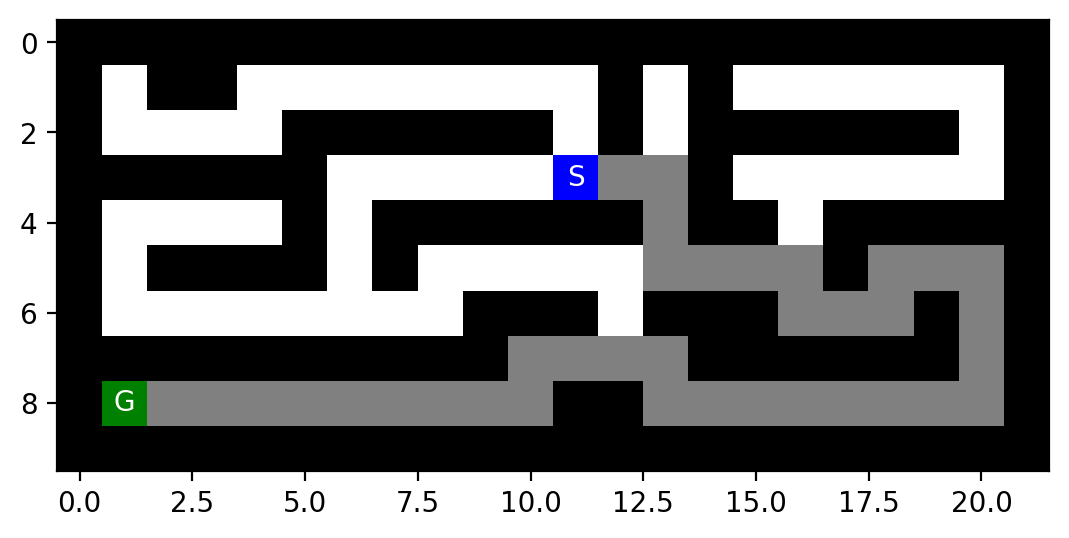

Total cost:  37
Total nodes expanded:  37
Max tree depth:  37
Total nodes in memory:  44
Max frontier size:  7

Greedy Best-First search
Solution:


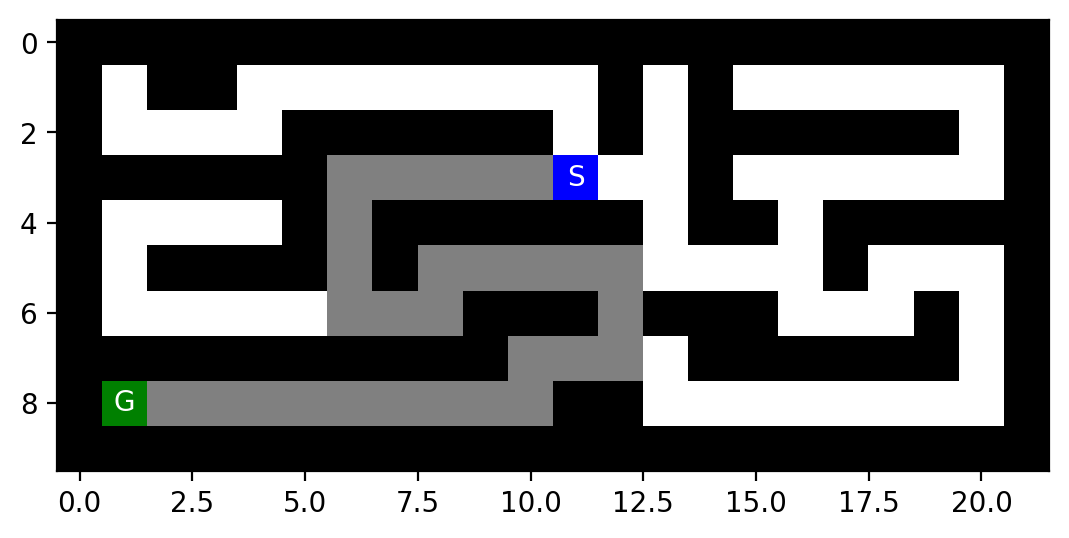

Total cost:  29
Total nodes expanded:  39
Max tree depth:  29
Total nodes in memory:  44
Max frontier size:  5

A* search
Solution:


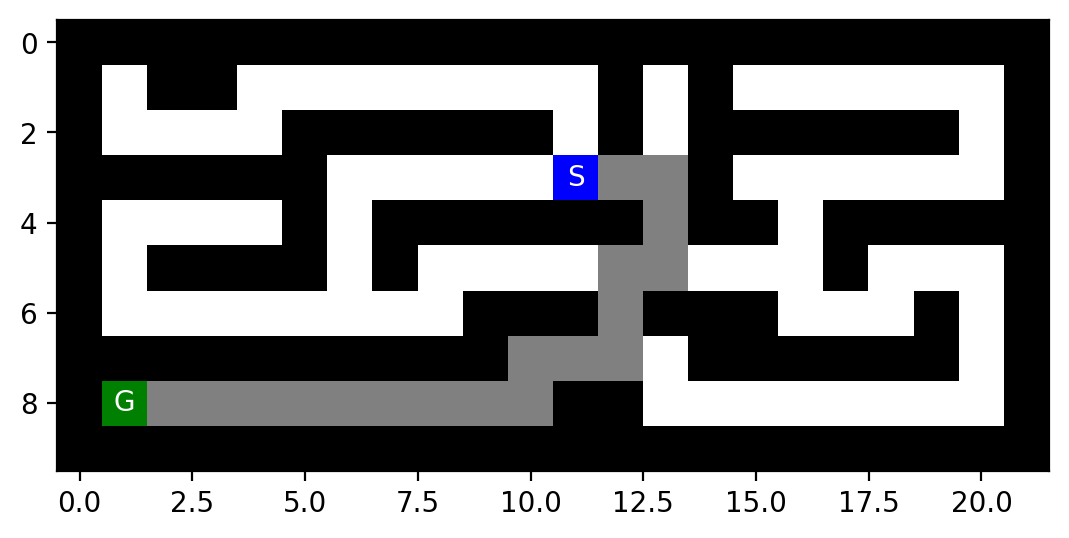

Total cost:  19
Total nodes expanded:  53
Max tree depth:  19
Total nodes in memory:  59
Max frontier size:  8

 medium_maze.txt 

Breadth-First search
Solution:


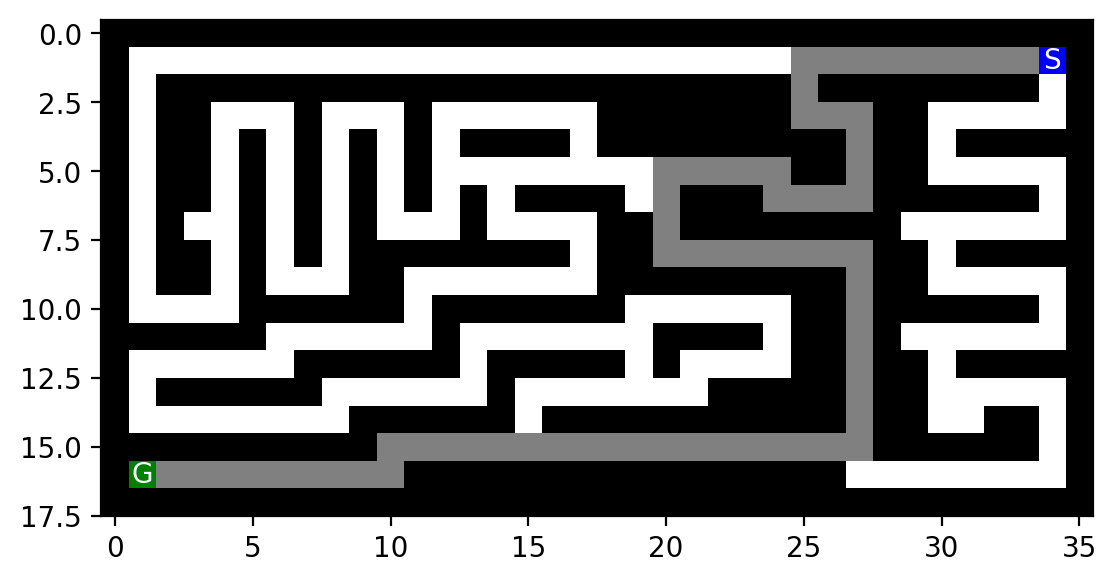

Total cost:  68
Total nodes expanded:  269
Max tree depth:  68
Total nodes in memory:  272
Max frontier size:  8

Depth-First search
Solution:


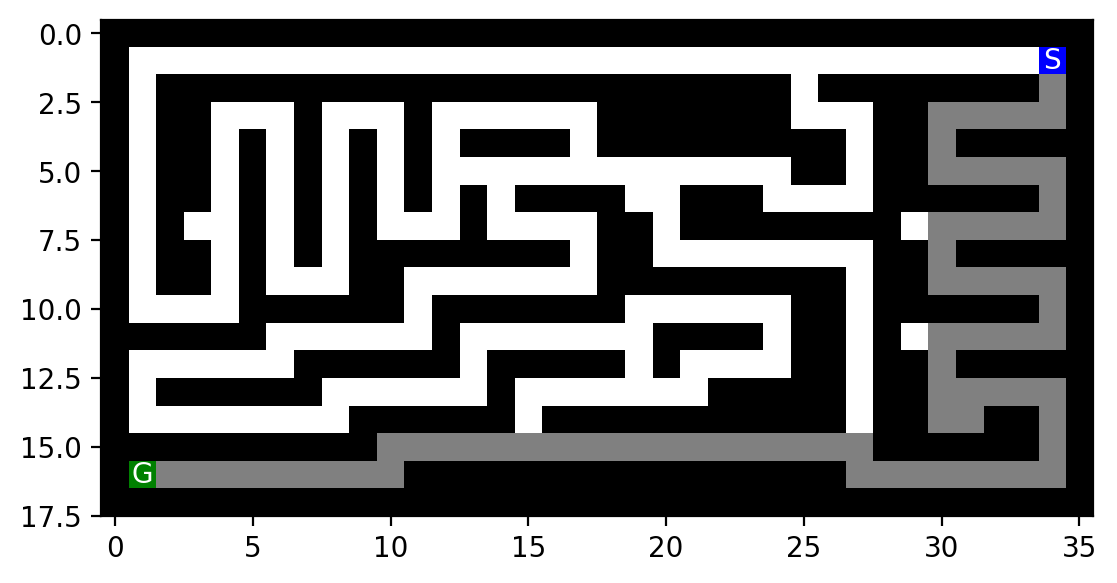

Total cost:  76
Total nodes expanded:  76
Max tree depth:  76
Total nodes in memory:  83
Max frontier size:  7

Greedy Best-First search
Solution:


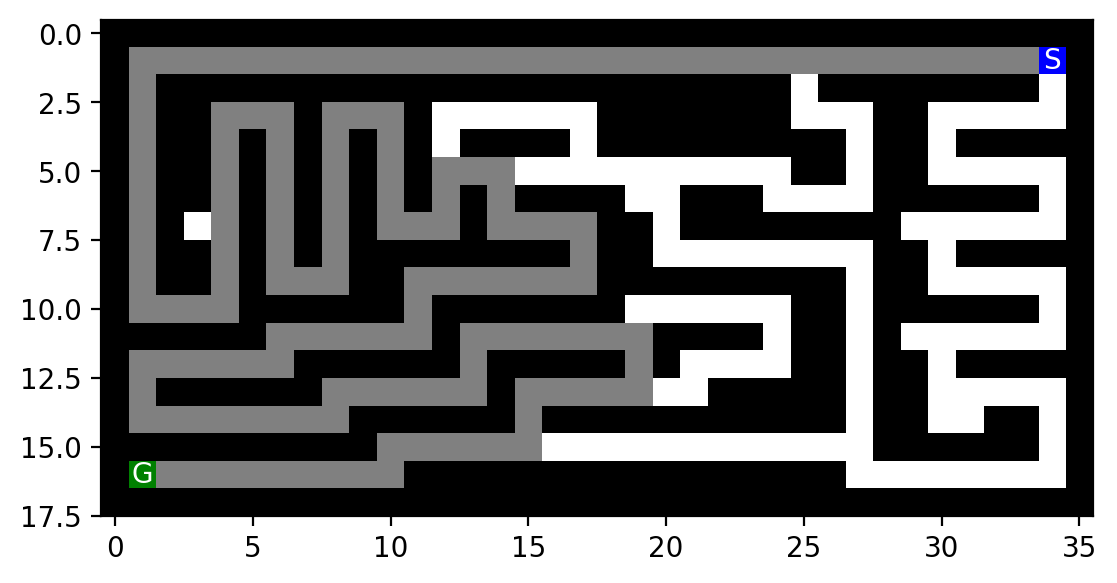

Total cost:  152
Total nodes expanded:  157
Max tree depth:  152
Total nodes in memory:  165
Max frontier size:  8

A* search
Solution:


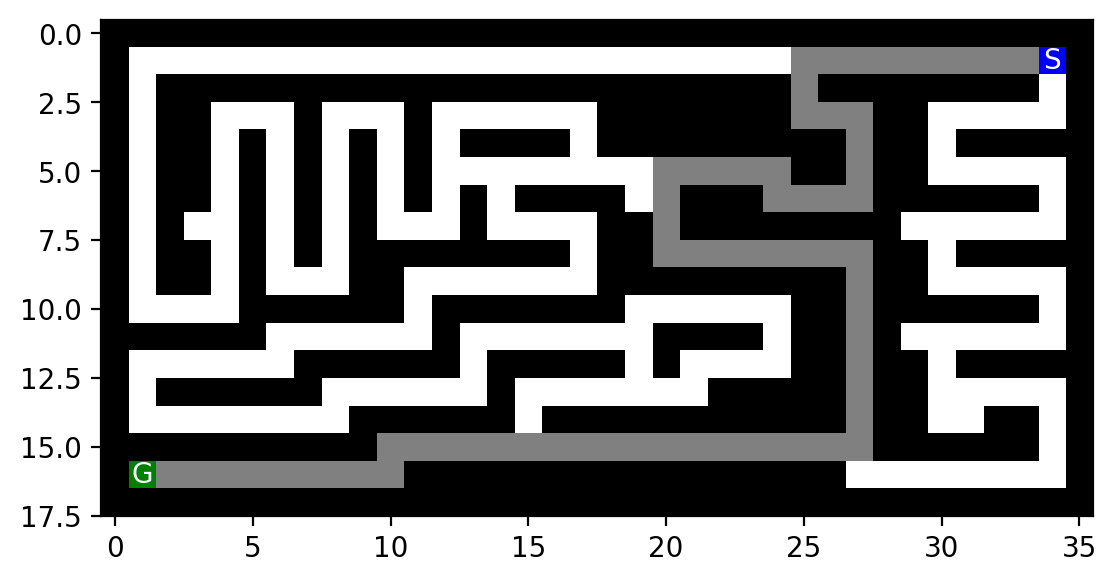

Total cost:  68
Total nodes expanded:  221
Max tree depth:  68
Total nodes in memory:  228
Max frontier size:  8

 large_maze.txt 

Breadth-First search
Solution:


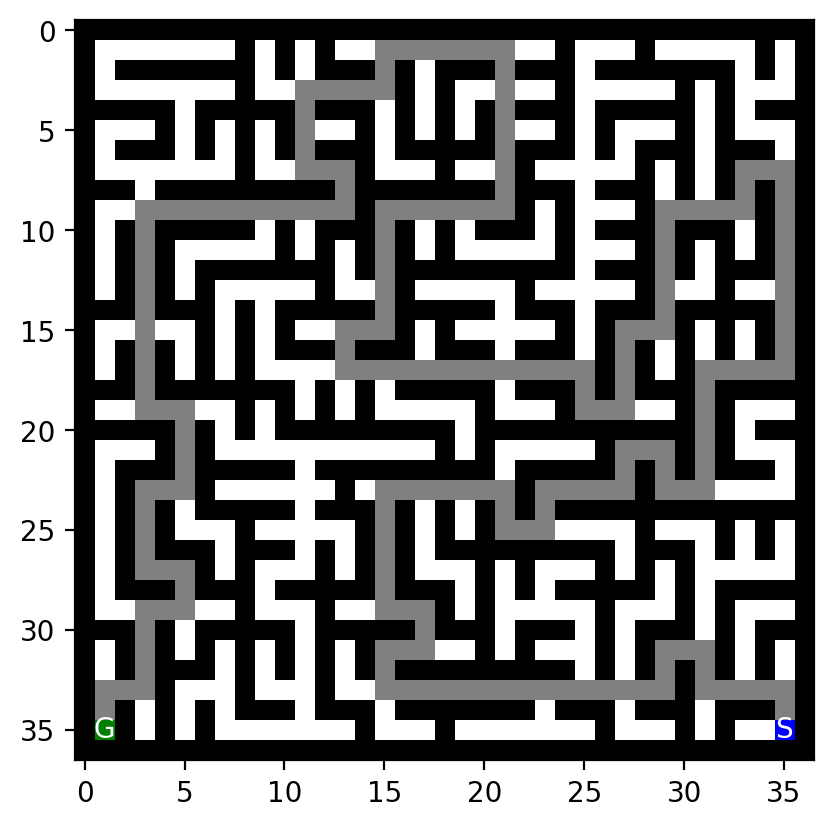

Total cost:  210
Total nodes expanded:  620
Max tree depth:  210
Total nodes in memory:  624
Max frontier size:  9

Depth-First search
Solution:


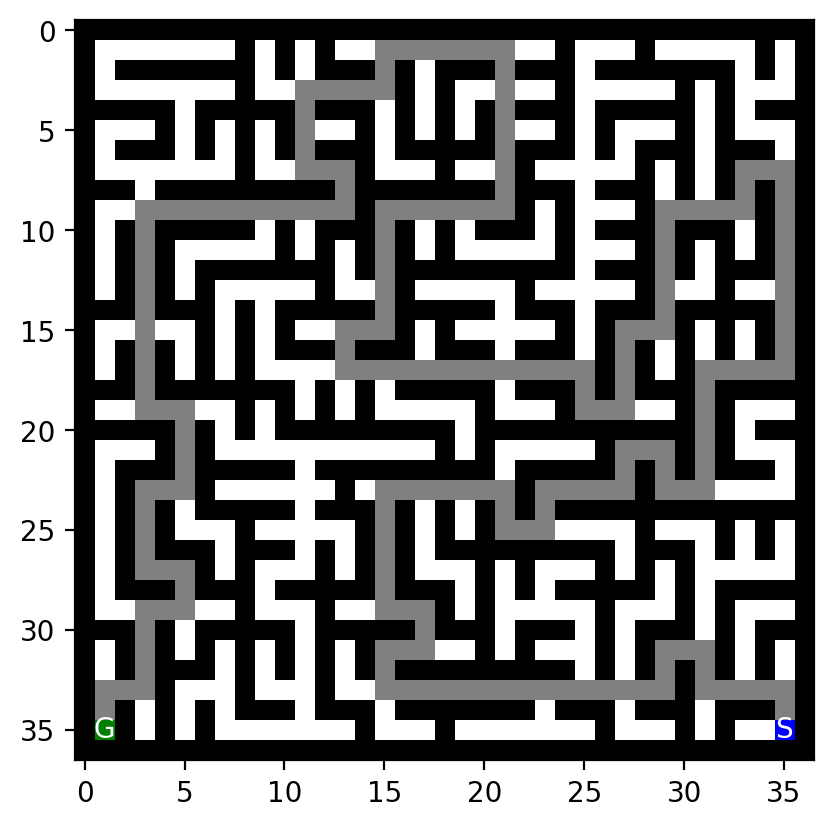

Total cost:  210
Total nodes expanded:  364
Max tree depth:  210
Total nodes in memory:  395
Max frontier size:  31

Greedy Best-First search
Solution:


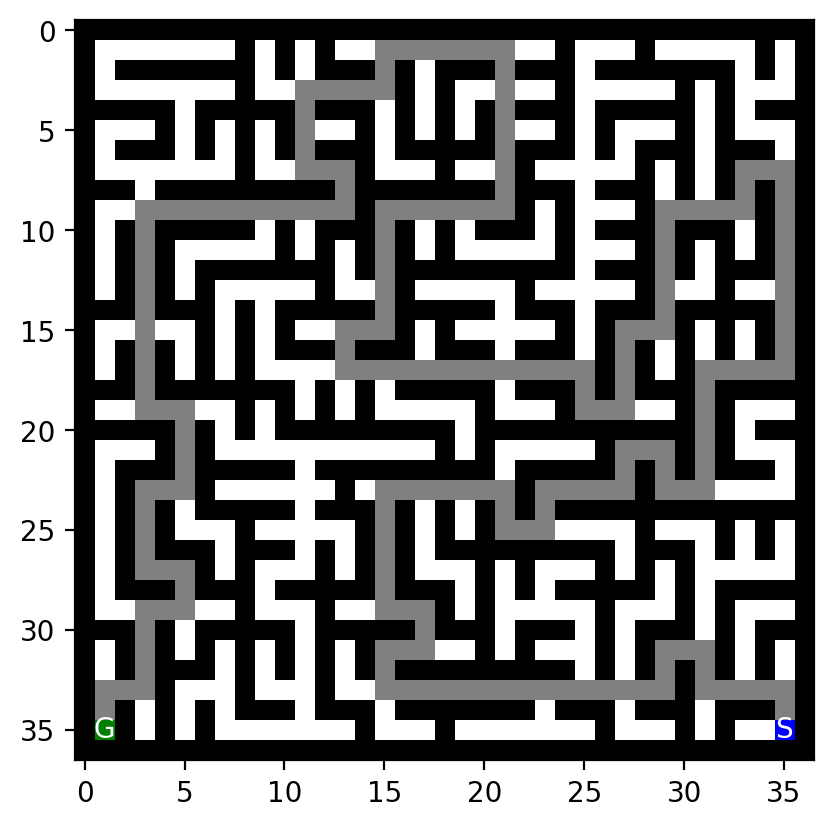

Total cost:  210
Total nodes expanded:  455
Max tree depth:  210
Total nodes in memory:  479
Max frontier size:  24

A* search
Solution:


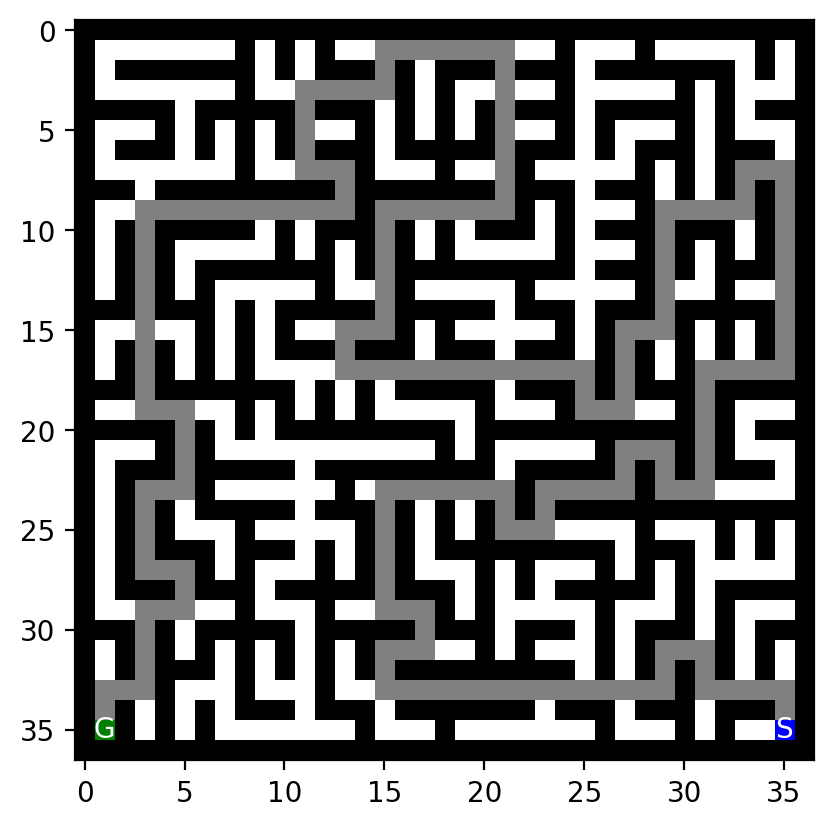

Total cost:  210
Total nodes expanded:  549
Max tree depth:  210
Total nodes in memory:  557
Max frontier size:  12

 open_maze.txt 

Breadth-First search
Solution:


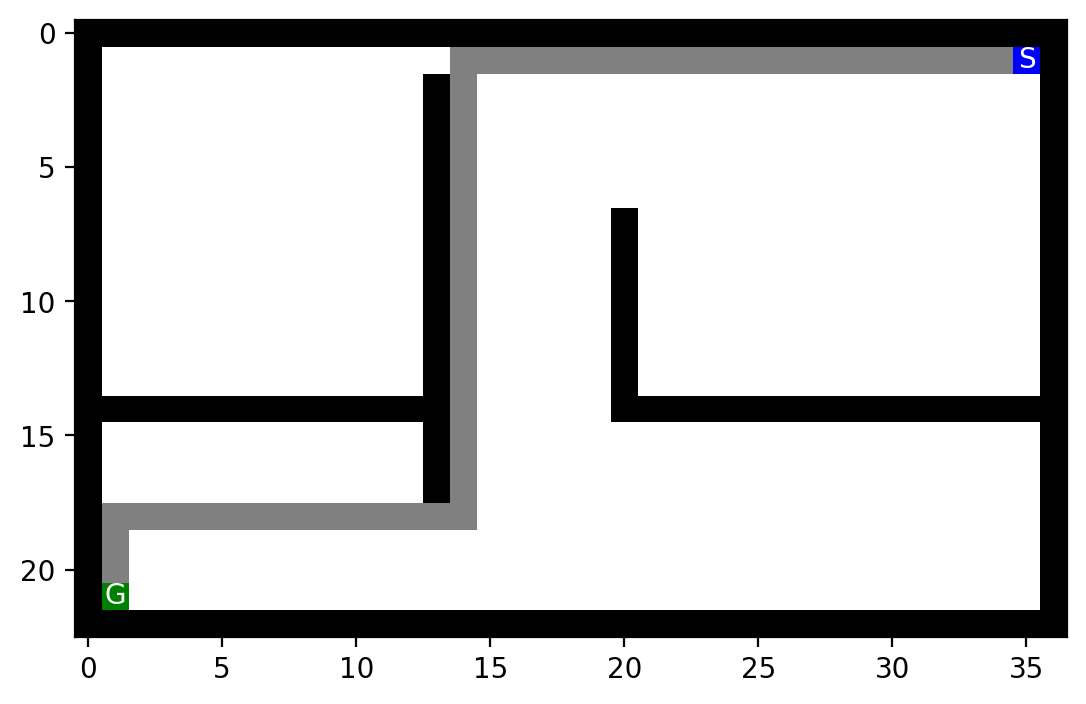

Total cost:  54
Total nodes expanded:  682
Max tree depth:  54
Total nodes in memory:  685
Max frontier size:  23

Depth-First search
Solution:


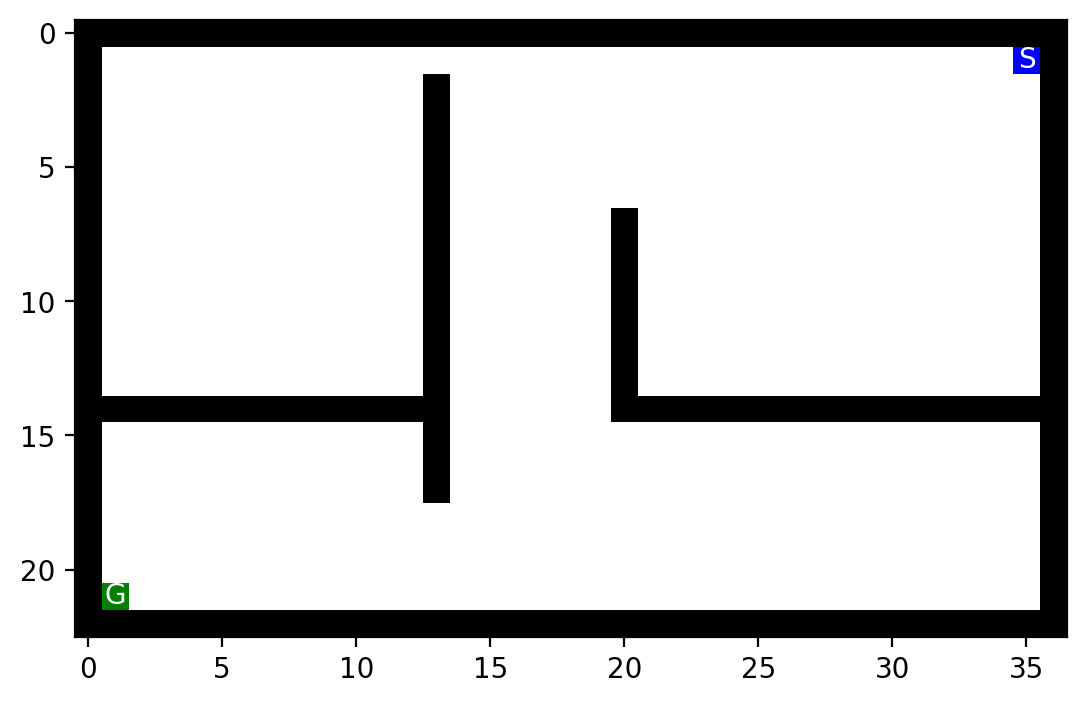

Total cost:  0
Total nodes expanded:  N/A
Max tree depth:  N/A
Total nodes in memory:  N/A
Max frontier size:  N/A

Greedy Best-First search
Solution:


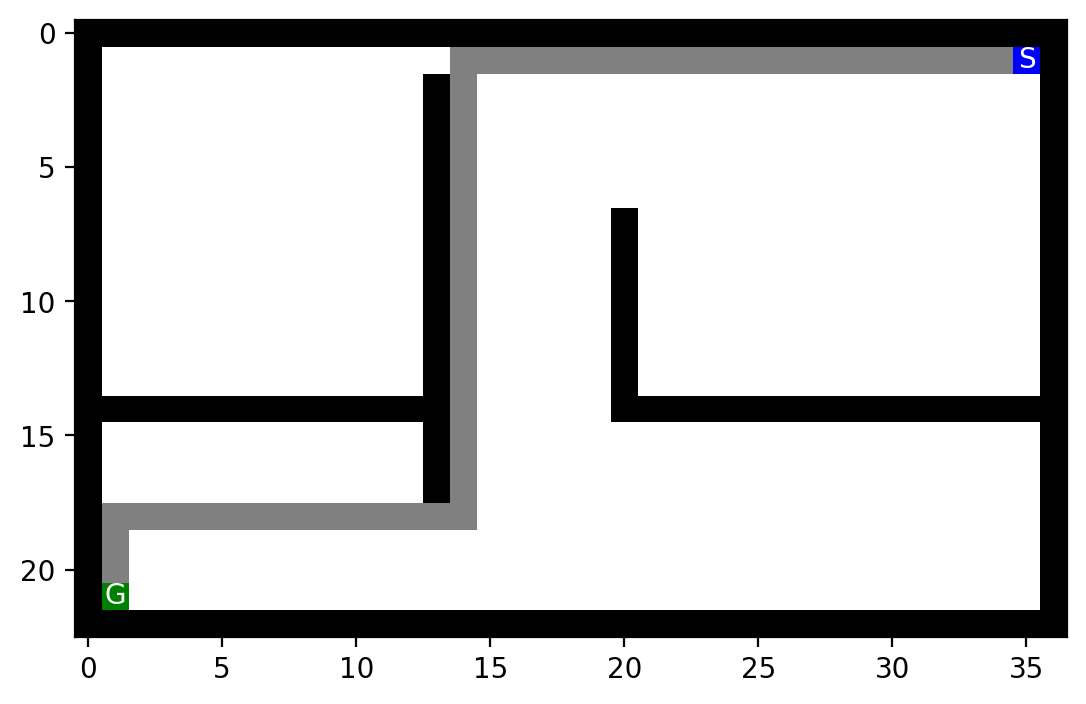

Total cost:  54
Total nodes expanded:  211
Max tree depth:  58
Total nodes in memory:  275
Max frontier size:  63

A* search
Solution:


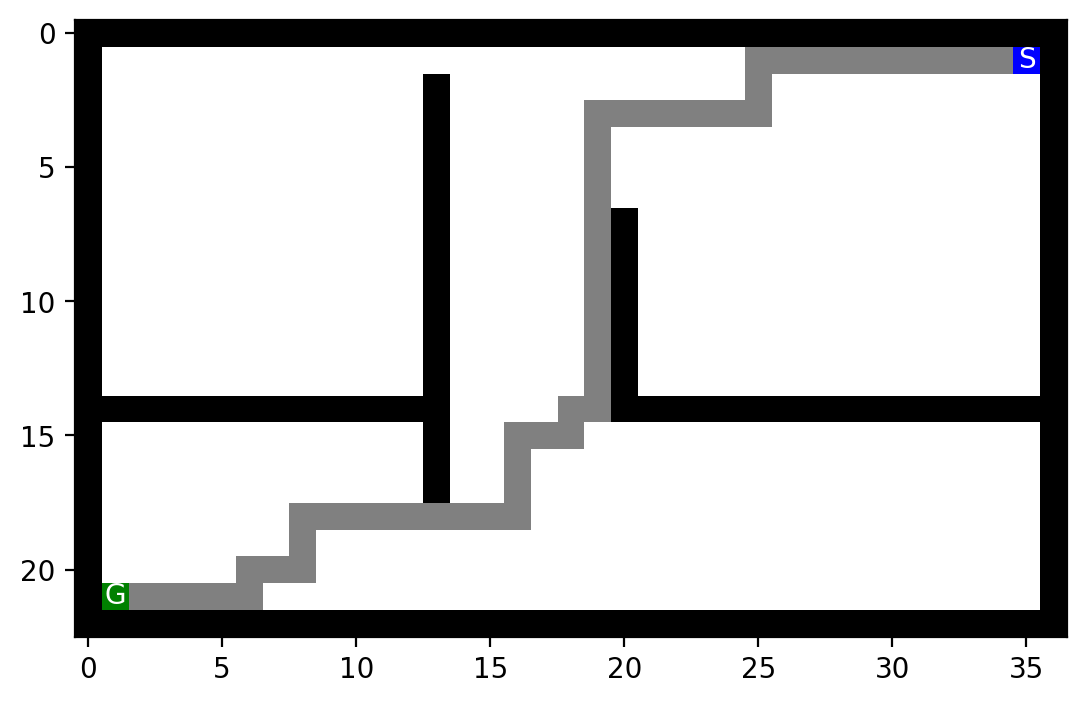

Total cost:  54
Total nodes expanded:  534
Max tree depth:  54
Total nodes in memory:  555
Max frontier size:  28

 wall_maze.txt 

Breadth-First search
Solution:


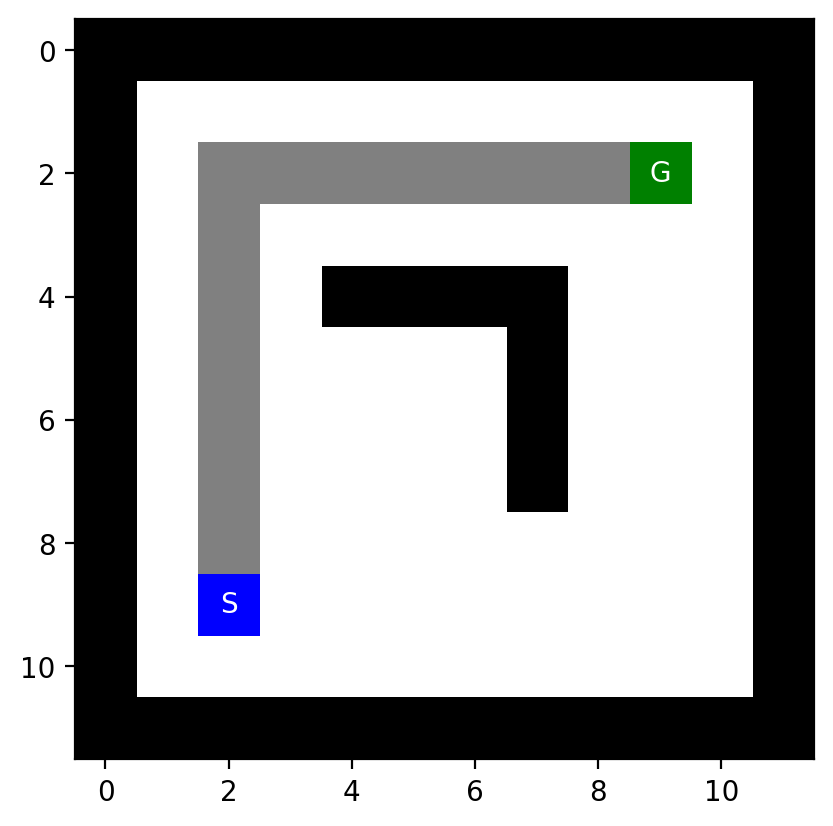

Total cost:  14
Total nodes expanded:  86
Max tree depth:  14
Total nodes in memory:  90
Max frontier size:  11

Depth-First search
Solution:


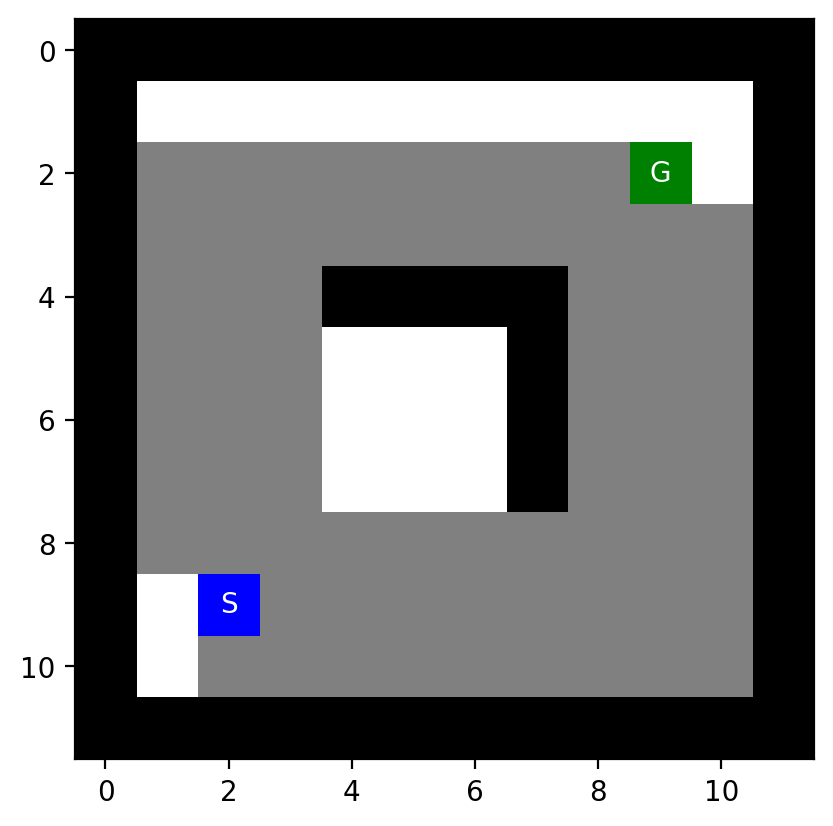

Total cost:  70
Total nodes expanded:  151
Max tree depth:  70
Total nodes in memory:  213
Max frontier size:  62

Greedy Best-First search
Solution:


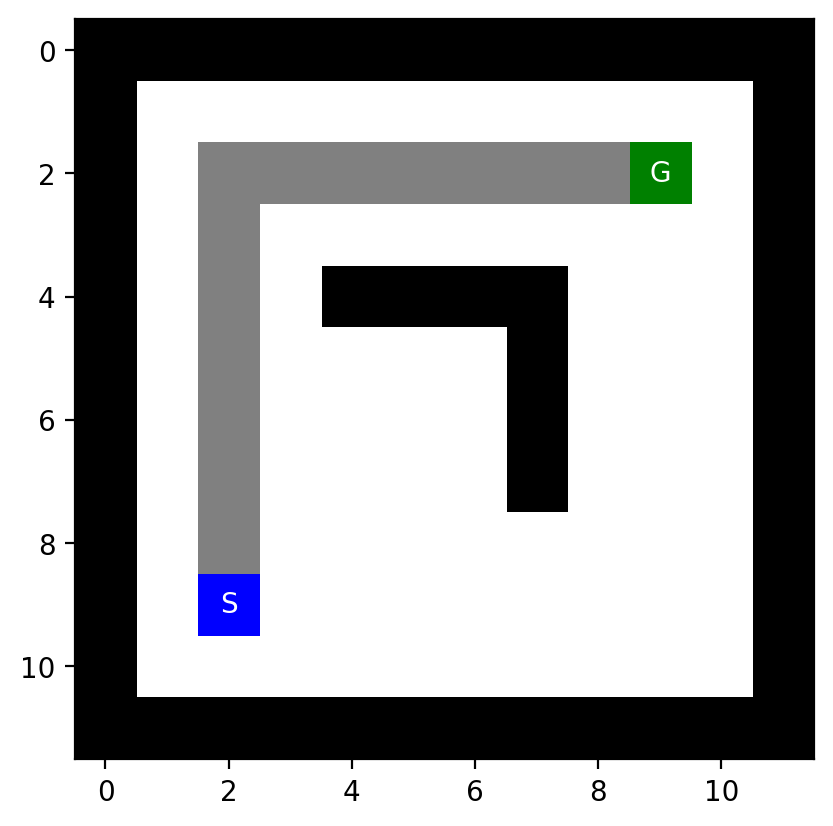

Total cost:  14
Total nodes expanded:  14
Max tree depth:  14
Total nodes in memory:  42
Max frontier size:  27

A* search
Solution:


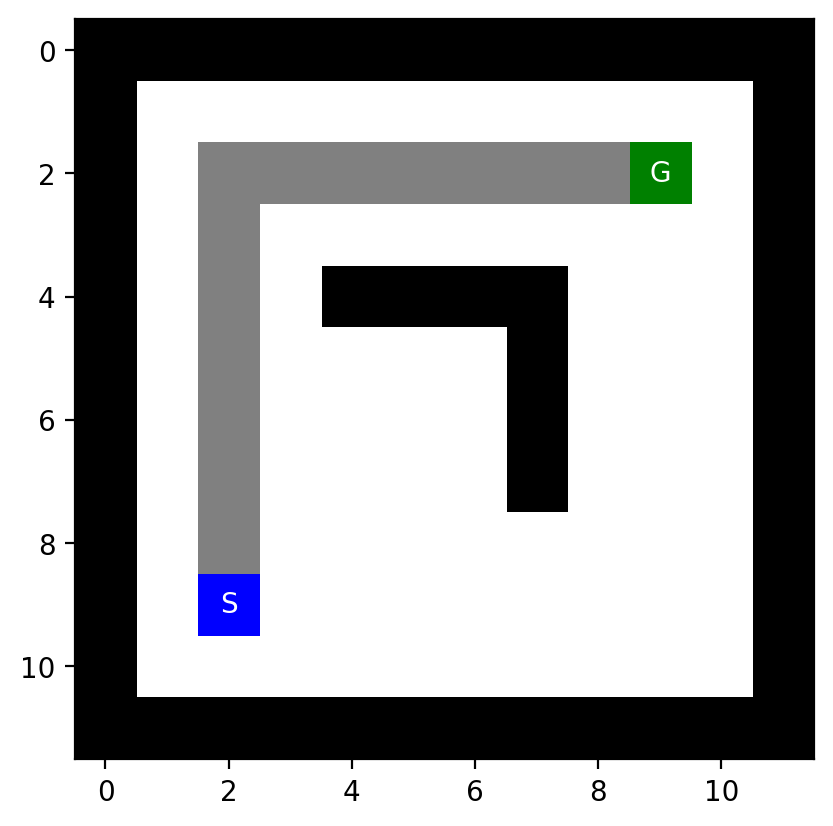

Total cost:  14
Total nodes expanded:  55
Max tree depth:  14
Total nodes in memory:  86
Max frontier size:  30

 loops_maze.txt 

Breadth-First search
Solution:


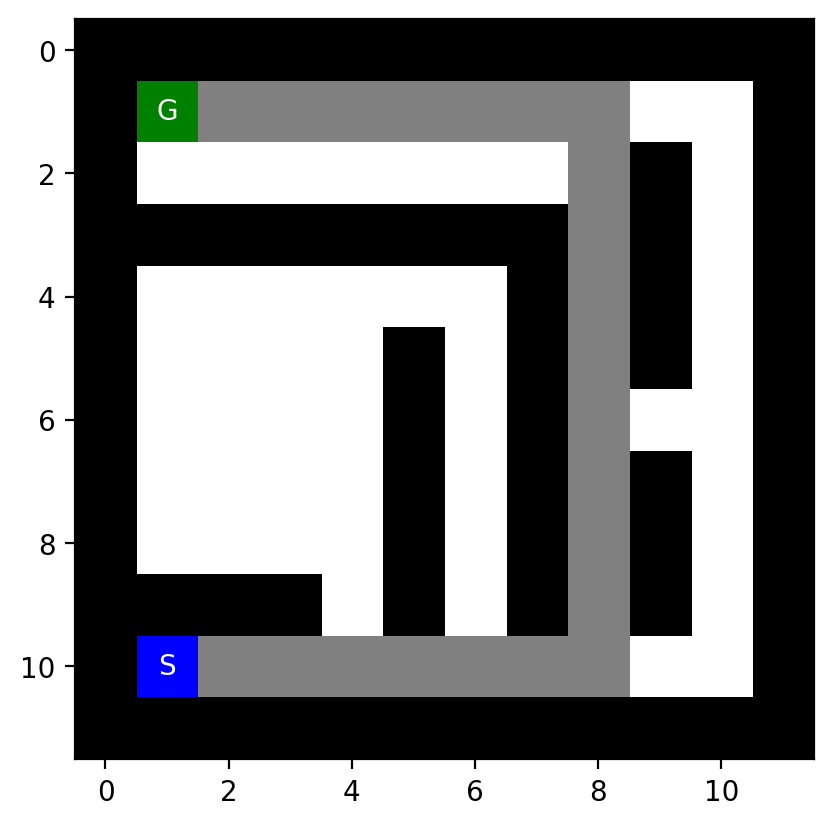

Total cost:  23
Total nodes expanded:  71
Max tree depth:  23
Total nodes in memory:  73
Max frontier size:  8

Depth-First search
Solution:


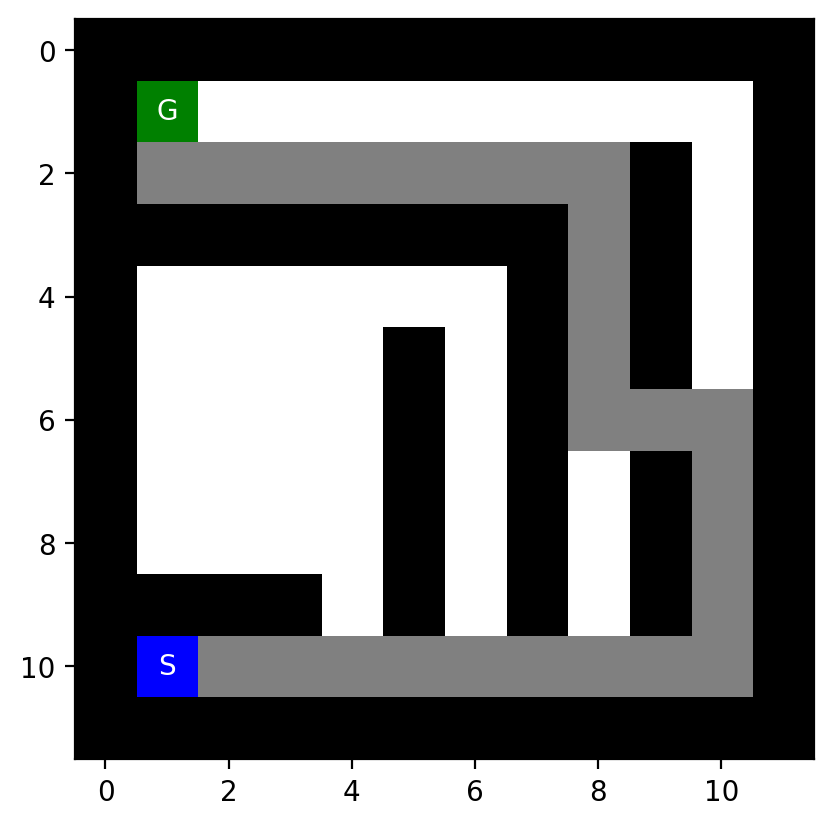

Total cost:  27
Total nodes expanded:  30
Max tree depth:  27
Total nodes in memory:  42
Max frontier size:  12

Greedy Best-First search
Solution:


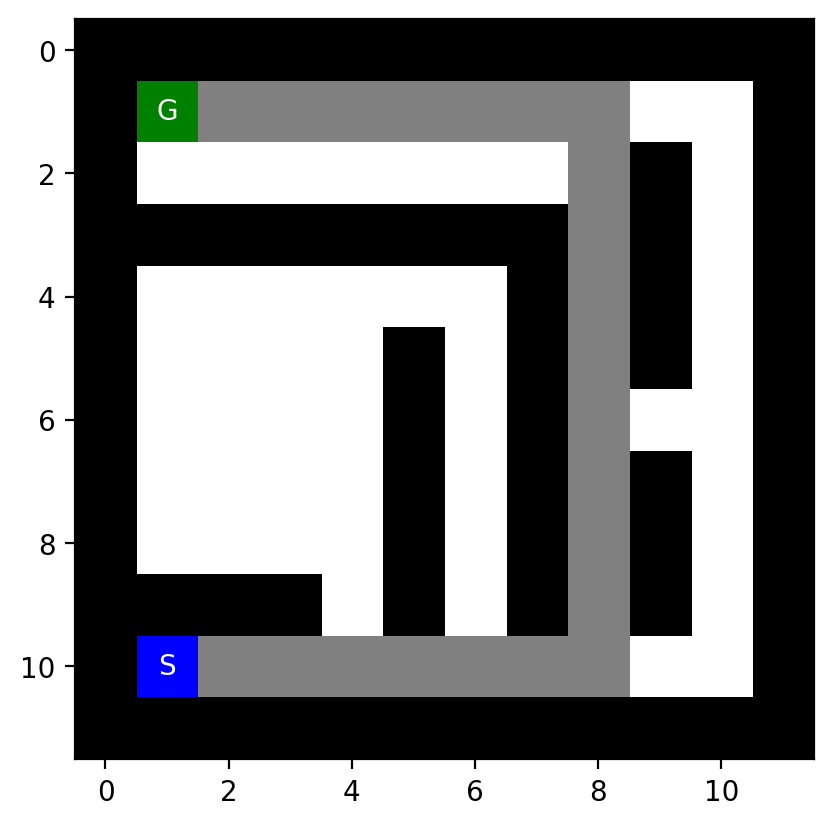

Total cost:  23
Total nodes expanded:  51
Max tree depth:  23
Total nodes in memory:  60
Max frontier size:  9

A* search
Solution:


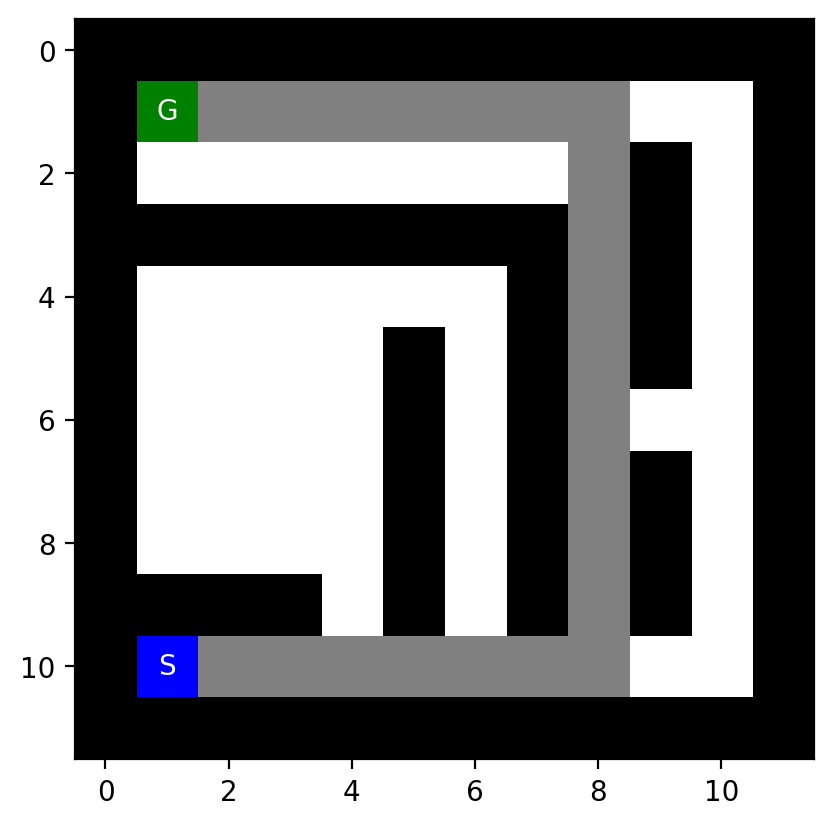

Total cost:  23
Total nodes expanded:  57
Max tree depth:  23
Total nodes in memory:  62
Max frontier size:  6

 empty_maze.txt 

Breadth-First search
Solution:


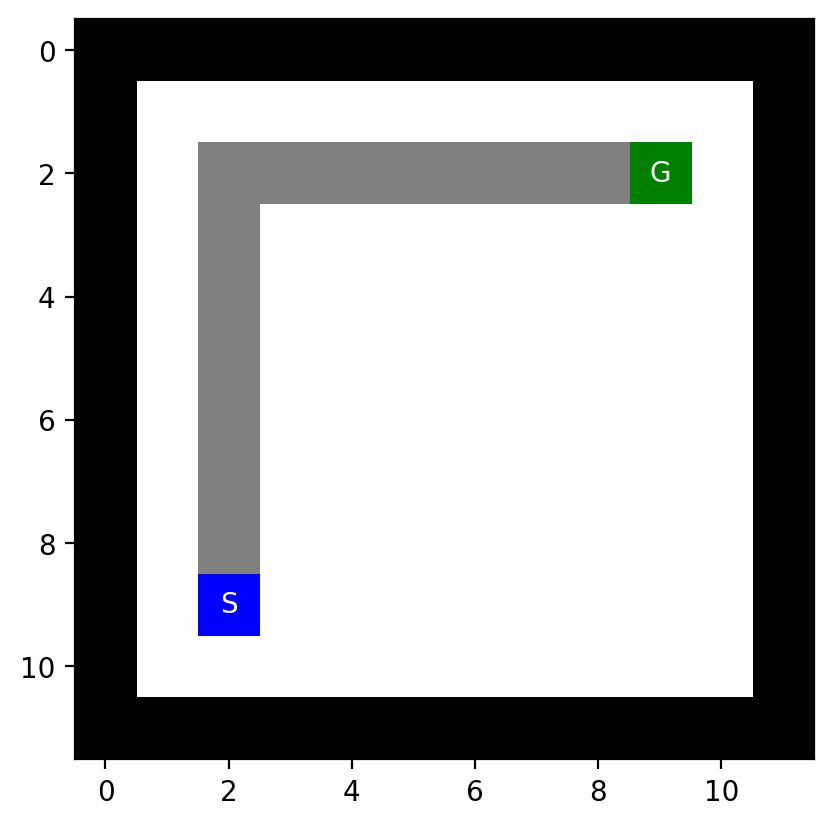

Total cost:  14
Total nodes expanded:  93
Max tree depth:  14
Total nodes in memory:  97
Max frontier size:  12

Depth-First search
Solution:


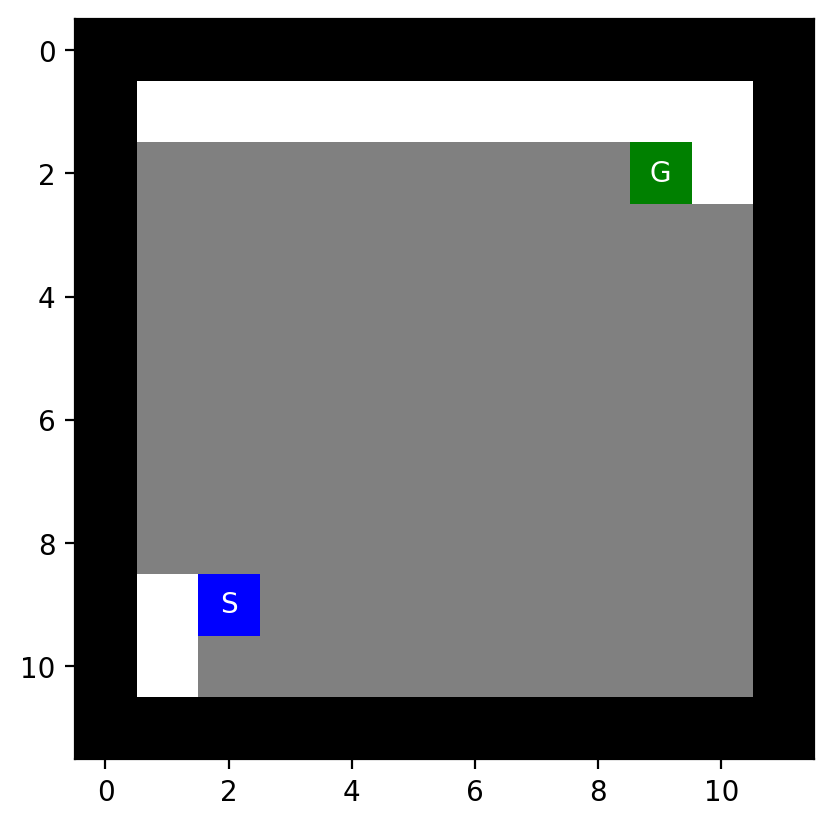

Total cost:  86
Total nodes expanded:  88
Max tree depth:  86
Total nodes in memory:  169
Max frontier size:  81

Greedy Best-First search
Solution:


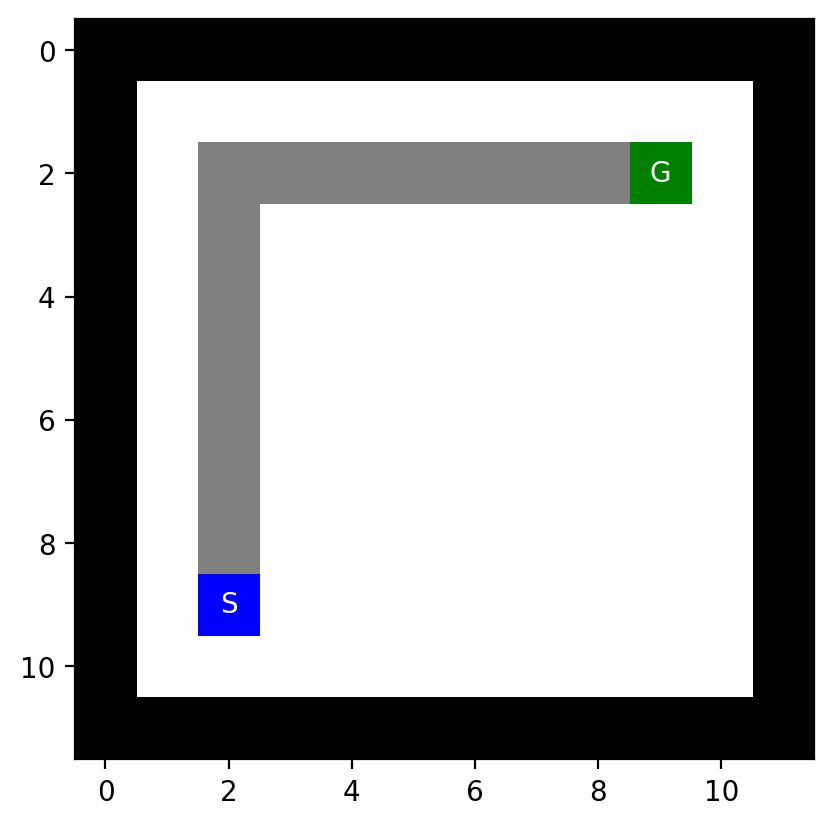

Total cost:  14
Total nodes expanded:  14
Max tree depth:  14
Total nodes in memory:  42
Max frontier size:  27

A* search
Solution:


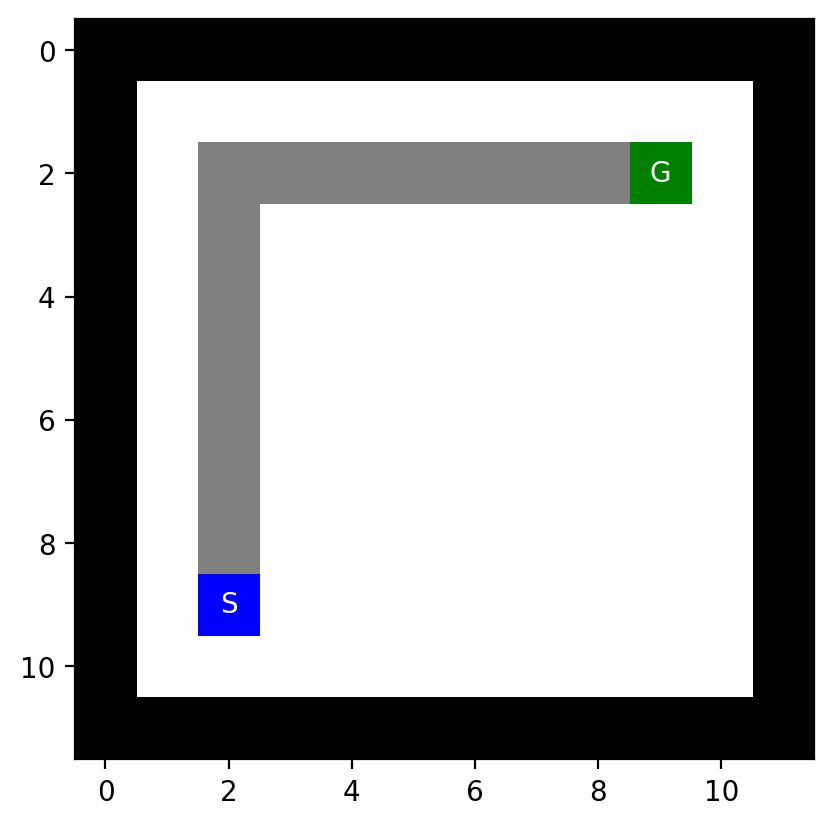

Total cost:  14
Total nodes expanded:  62
Max tree depth:  14
Total nodes in memory:  93
Max frontier size:  30

 empty_2_maze.txt 

Breadth-First search
Solution:


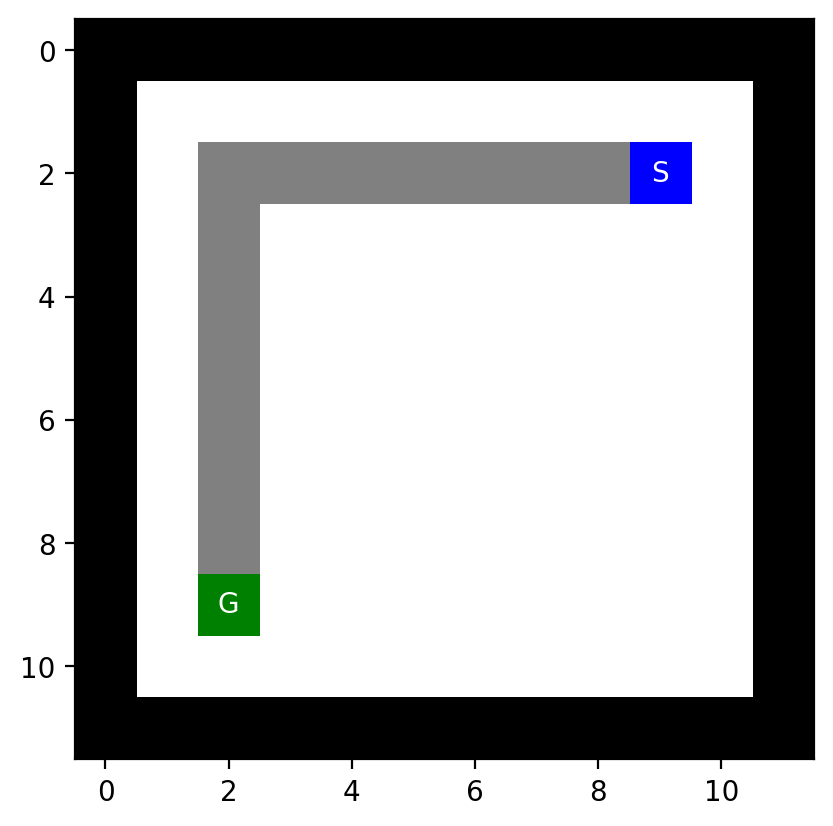

Total cost:  14
Total nodes expanded:  93
Max tree depth:  14
Total nodes in memory:  97
Max frontier size:  11

Depth-First search
Solution:


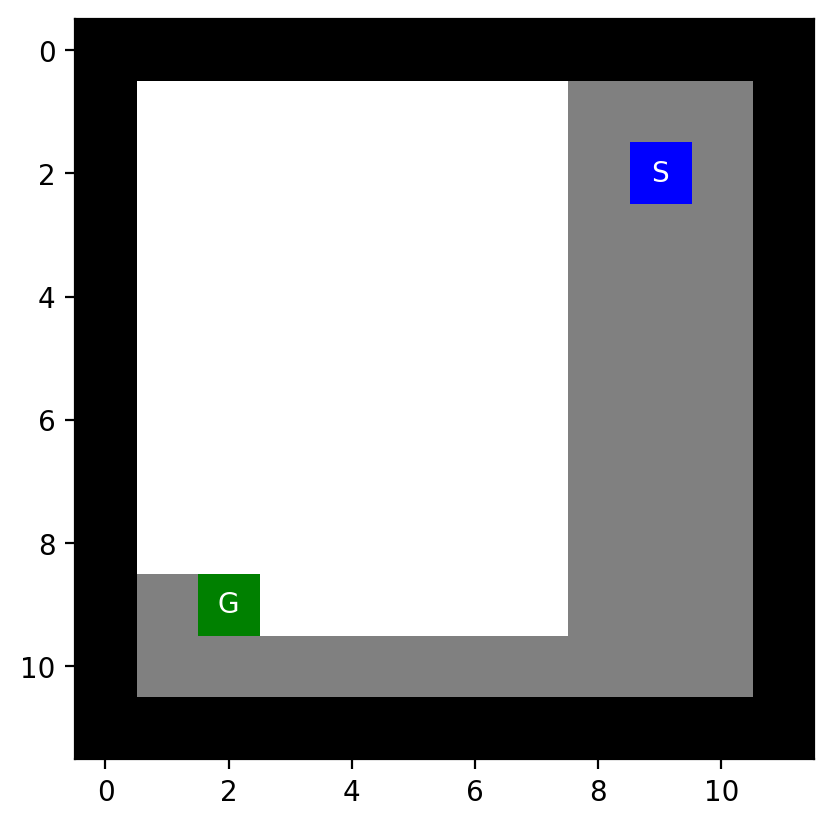

Total cost:  38
Total nodes expanded:  38
Max tree depth:  38
Total nodes in memory:  73
Max frontier size:  35

Greedy Best-First search
Solution:


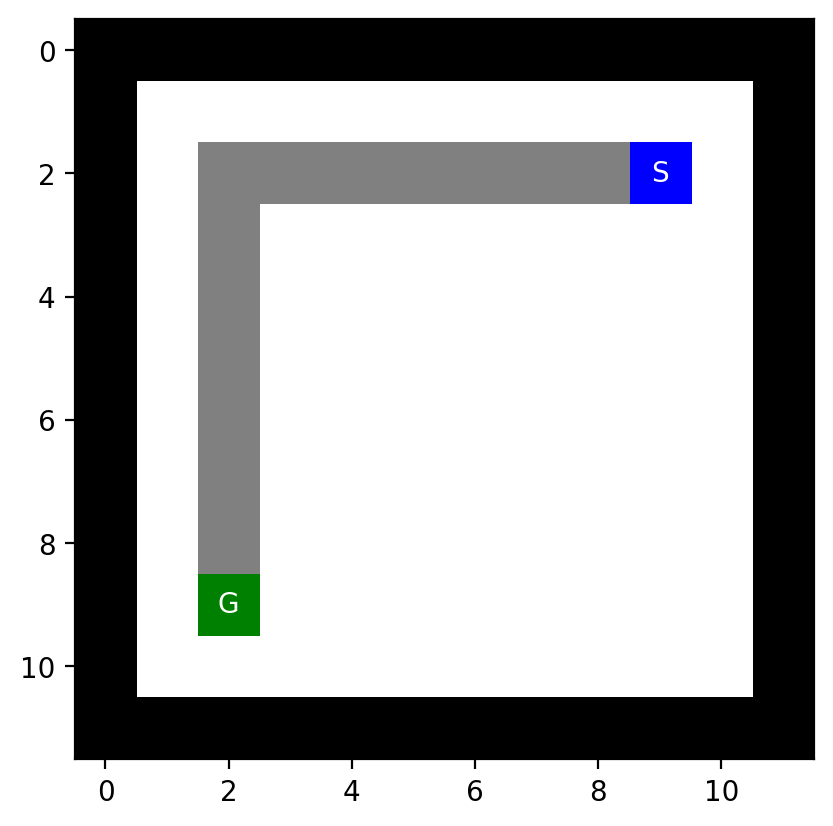

Total cost:  14
Total nodes expanded:  14
Max tree depth:  14
Total nodes in memory:  43
Max frontier size:  28

A* search
Solution:


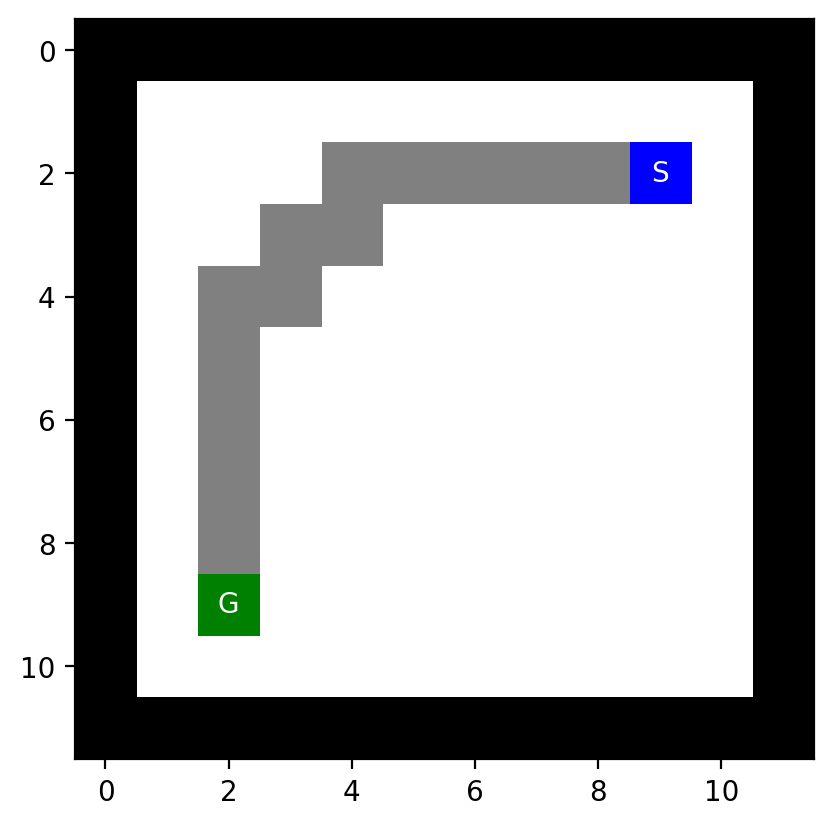

Total cost:  14
Total nodes expanded:  62
Max tree depth:  14
Total nodes in memory:  93
Max frontier size:  30


In [11]:
maze_files = [
    "small_maze.txt",
    "medium_maze.txt",
    "large_maze.txt",
    "open_maze.txt",
    "wall_maze.txt",
    "loops_maze.txt",
    "empty_maze.txt",
    "empty_2_maze.txt",
]


maze_data = {}
for file in maze_files:
    with open(file, "r") as f:
        maze_data[file] = f.read()
        
    #  The solution and its path cost
    #  Total number of nodes expanded
    #  Maximum tree depth
    #  Maximum size of the frontier
    

for maze_name, string in maze_data.items():
    print("\n", maze_name, "\n")
    maze = mh.parse_maze(string)
    start = mh.find_pos(maze, what="S")
    goal = mh.find_pos(maze, what="G")
    
    print("Breadth-First search")
    
    result = bfs_maze_search(maze)
    
    print("Solution:")
    
    for node in result["solution"]:
        if node.pos not in [goal, start]:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)
    
    print("Total cost: ", result["solution"][-1].cost)
    print("Total nodes expanded: ", result["total nodes"])
    print("Max tree depth: ", result["max tree depth"])
    print("Total nodes in memory: ", result["nodes in memory"])
    print("Max frontier size: ", result["max frontier len"])

    maze = mh.parse_maze(string)
    
    print("\nDepth-First search")
    
    if maze_name != "open_maze.txt":
        result = dfs_maze_search(maze)
    else:
        result = {
            "solution" : [Node(mh.find_pos(maze,what = 'G'), None, None, 0)],
            "total nodes" : "N/A",
            "nodes in memory" : "N/A",
            "max tree depth" : "N/A",
            "max frontier len" : "N/A"
        }
    
    
    print("Solution:")
    
    for node in result["solution"]:
        if node.pos not in [goal, start]:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)
    
    print("Total cost: ", result["solution"][-1].cost)
    print("Total nodes expanded: ", result["total nodes"])
    print("Max tree depth: ", result["max tree depth"])
    print("Total nodes in memory: ", result["nodes in memory"])
    print("Max frontier size: ", result["max frontier len"])

    maze = mh.parse_maze(string)
    
    
    print("\nGreedy Best-First search")
    
    result = greedy_bestfs_maze_search(maze, manhattan_distance)
    
    print("Solution:")
    
    for node in result["solution"]:
        if node.pos not in [goal, start]:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)
    
    print("Total cost: ", result["solution"][-1].cost)
    print("Total nodes expanded: ", result["total nodes"])
    print("Max tree depth: ", result["max tree depth"])
    print("Total nodes in memory: ", result["nodes in memory"])
    print("Max frontier size: ", result["max frontier len"])

    maze = mh.parse_maze(string)
    print("\nA* search")
    
    print("Solution:")
    result = astar_maze_search(maze, manhattan_distance)
    for node in result["solution"]:
        if node.pos not in [goal, start]:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)

    print("Total cost: ", result["solution"][-1].cost)
    print("Total nodes expanded: ", result["total nodes"])
    print("Max tree depth: ", result["max tree depth"])
    print("Total nodes in memory: ", result["nodes in memory"])
    print("Max frontier size: ", result["max frontier len"])
   

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |    19     |      91        |       19       |        93     |         8         |
| DFS       |    37     |      37        |       37       |        44     |         7         |
| GBS       |    29     |      39        |       29       |        44     |         5         |
| A*        |    19     |      53        |       19       |        59     |         8         |

__Medium Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |    68     |      269       |       68       |       272     |          8        |
| DFS       |    76     |       76       |       76       |        83     |          7        |
| GBS       |   152     |      157       |      152       |       165     |          8        |
| A*        |    68     |      221       |       68       |       228     |          8        |

__Large maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |     210      |  620              |     210           |   624            |           9         |
| DFS       |     210      |  364              |     210           |   395            |          31         |
| GBS       |     210      |  455              |     210           |   479            |          24         |
| A*        |     210      |  549              |     210           |   557            |          12         |

__Open Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |      54     |   682             |    54            |   685            |         23          |
| DFS       |      N/A    |         N/A       |       N/A        |     N/A          |         N/A         |
| GBS       |      54     |   211             |    58            |   275            |         63          |
| A*        |      54     |   534             |    54            |   555            |         28          |

The error for open maze DFS is due to the time complexity of the worst case. The worst case for DFS time complexity is exponential to increasing maximum tree depth. This results in the search taking too much time.

__Wall maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |    14       |         86       |   14             |   90            |      11             |
| DFS       |    70       |         151      |   70             |  213            |      62             |
| GBS       |    14       |         14       |   14             |   42            |      27             |
| A*        |    14       |         55       |   14             |   86            |      30             |

__Loops Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |      23     |         71       |     23           |      73         |         8          |
| DFS       |      27     |         30       |     27           |      42         |        12          |
| GBS       |      23     |         51       |     23           |      60         |         9          |
| A*        |      23     |         57       |     23           |      62         |         6          |

__Empty Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |       14    |      93          |      14          |      97         |      12             |
| DFS       |       86    |      88          |      86          |     169         |      81             |
| GBS       |       14    |      14          |      14          |      42         |      27             |
| A*        |       14    |      62          |      14          |      93         |      30             |

__Empty 2 Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |       14    |      93          |      14          |      97         |      11             |
| DFS       |       38    |      38          |      38          |      73         |      35             |
| GBS       |       14    |      14          |      14          |      43         |      28             |
| A*        |       14    |      62          |      14          |      93         |      30             |

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

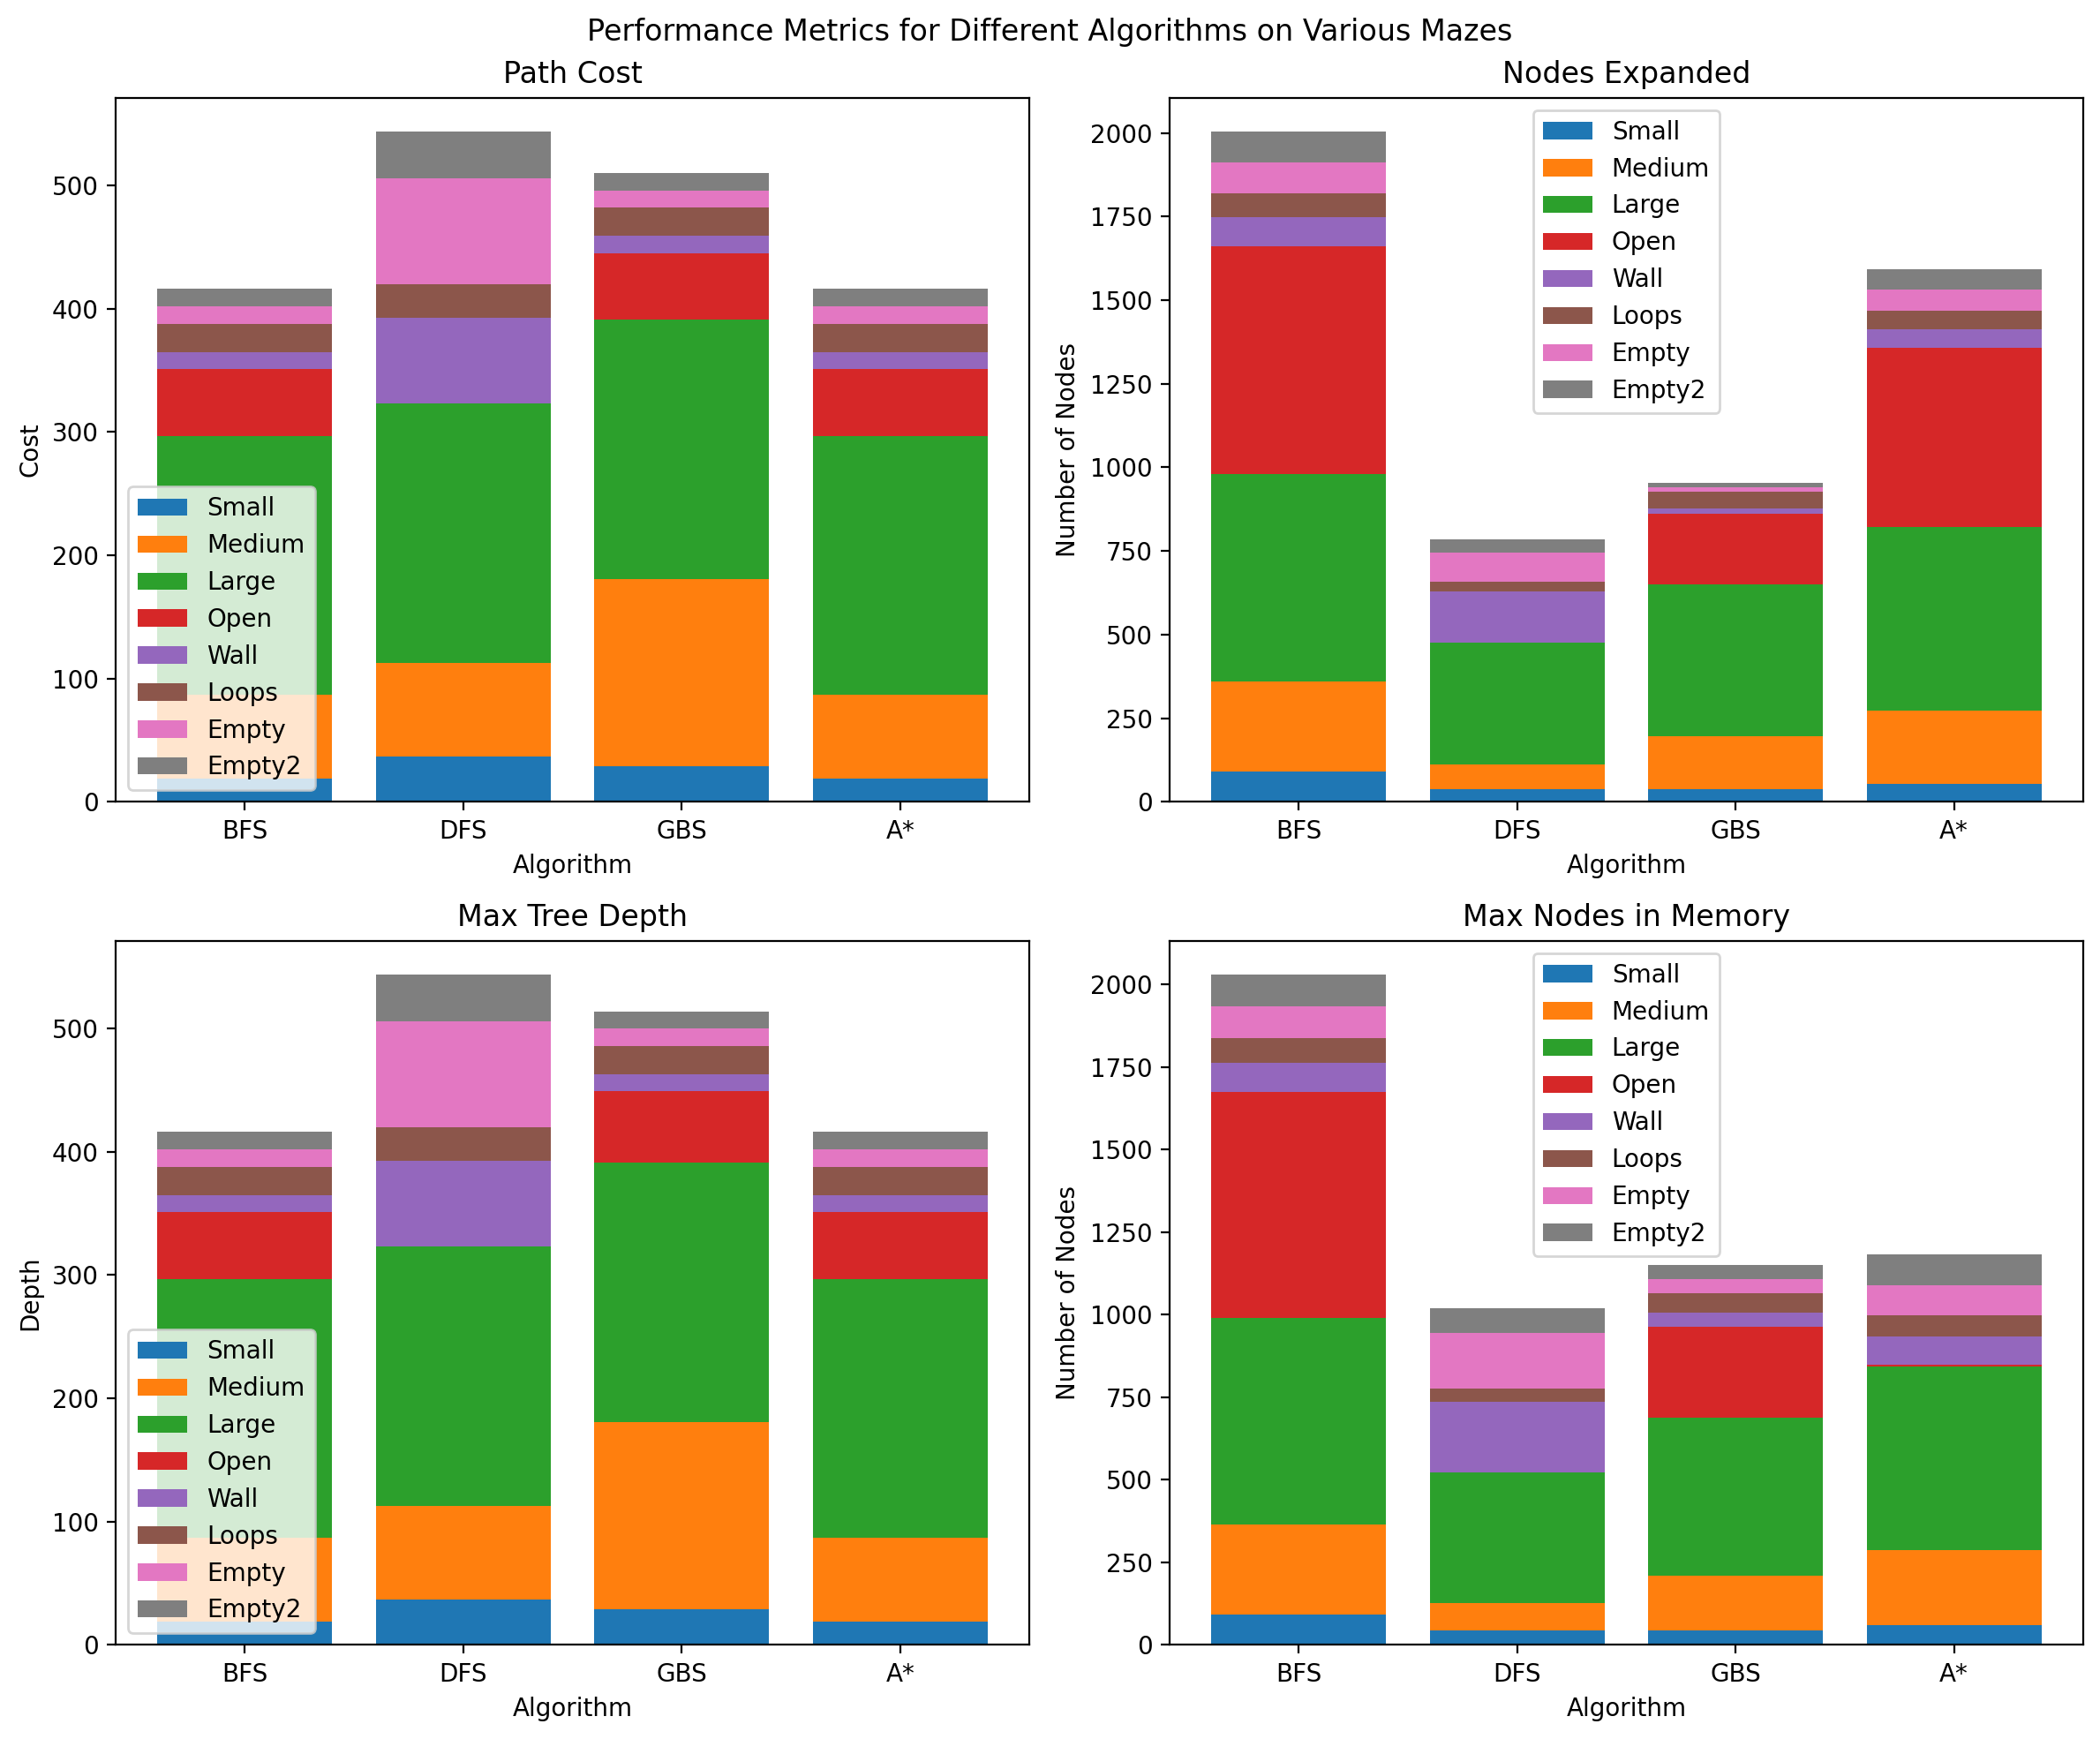

In [14]:
import numpy as np
import matplotlib.pyplot as plt

algorithms = ["BFS", "DFS", "GBS", "A*"]
path_cost = {"Small": [19, 37, 29, 19], "Medium": [68, 76, 152, 68], "Large": [210, 210, 210, 210],
             "Open": [54, 0, 54, 54], "Wall": [14, 70, 14, 14], "Loops": [23, 27, 23, 23],
             "Empty": [14, 86, 14, 14], "Empty2": [14, 38, 14, 14]}

nodes_expanded = {"Small": [91, 37, 39, 53], "Medium": [269, 76, 157, 221], "Large": [620, 364, 455, 549],
                  "Open": [682, 0, 211, 534], "Wall": [86, 151, 14, 55], "Loops": [71, 30, 51, 57],
                  "Empty": [93, 88, 14, 62], "Empty2": [93, 38, 14, 62]}

max_tree_depth = {"Small": [19, 37, 29, 19], "Medium": [68, 76, 152, 68], "Large": [210, 210, 210, 210],
                  "Open": [54, 0, 58, 54], "Wall": [14, 70, 14, 14], "Loops": [23, 27, 23, 23],
                  "Empty": [14, 86, 14, 14], "Empty2": [14, 38, 14, 14]}

max_nodes_in_memory = {"Small": [93, 44, 44, 59], "Medium": [272, 83, 165, 228], "Large": [624, 395, 479, 557],
                       "Open": [685, 0, 275, 5], "Wall": [90, 213, 42, 86], "Loops": [73, 42, 60, 62],
                       "Empty": [97, 169, 42, 93], "Empty2": [97, 73, 43, 93]}

max_frontier_size = {"Small": [8, 7, 5, 8], "Medium": [8, 7, 8, 8], "Large": [9, 31, 24, 12],
                     "Open": [23, 0, 63, 28], "Wall": [11, 62, 27, 30], "Loops": [8, 12, 9, 6],
                     "Empty": [12, 81, 27, 30], "Empty2": [11, 35, 28, 30]}


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

fig.suptitle("Performance Metrics for Different Algorithms on Various Mazes")


axs[0, 0].bar(algorithms, path_cost["Small"], label="Small")
axs[0, 0].bar(algorithms, path_cost["Medium"], bottom=path_cost["Small"], label="Medium")
axs[0, 0].bar(algorithms, path_cost["Large"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]), label="Large")
axs[0, 0].bar(algorithms, path_cost["Open"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]) + np.array(path_cost["Large"]), label="Open")
axs[0, 0].bar(algorithms, path_cost["Wall"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]) + np.array(path_cost["Large"]) + np.array(path_cost["Open"]), label="Wall")
axs[0, 0].bar(algorithms, path_cost["Loops"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]) + np.array(path_cost["Large"]) + np.array(path_cost["Open"]) + np.array(path_cost["Wall"]), label="Loops")
axs[0, 0].bar(algorithms, path_cost["Empty"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]) + np.array(path_cost["Large"]) + np.array(path_cost["Open"]) + np.array(path_cost["Wall"]) + np.array(path_cost["Loops"]), label="Empty")
axs[0, 0].bar(algorithms, path_cost["Empty2"], bottom=np.array(path_cost["Small"]) + np.array(path_cost["Medium"]) + np.array(path_cost["Large"]) + np.array(path_cost["Open"]) + np.array(path_cost["Wall"]) + np.array(path_cost["Loops"]) + np.array(path_cost["Empty"]), label="Empty2")
axs[0, 0].set_title("Path Cost")
axs[0, 0].legend()
axs[0, 0].set_ylabel("Cost")

axs[0, 1].bar(algorithms, nodes_expanded["Small"], label="Small")
axs[0, 1].bar(algorithms, nodes_expanded["Medium"], bottom=nodes_expanded["Small"], label="Medium")
axs[0, 1].bar(algorithms, nodes_expanded["Large"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]), label="Large")
axs[0, 1].bar(algorithms, nodes_expanded["Open"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]) + np.array(nodes_expanded["Large"]), label="Open")
axs[0, 1].bar(algorithms, nodes_expanded["Wall"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]) + np.array(nodes_expanded["Large"]) + np.array(nodes_expanded["Open"]), label="Wall")
axs[0, 1].bar(algorithms, nodes_expanded["Loops"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]) + np.array(nodes_expanded["Large"]) + np.array(nodes_expanded["Open"]) + np.array(nodes_expanded["Wall"]), label="Loops")
axs[0, 1].bar(algorithms, nodes_expanded["Empty"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]) + np.array(nodes_expanded["Large"]) + np.array(nodes_expanded["Open"]) + np.array(nodes_expanded["Wall"]) + np.array(nodes_expanded["Loops"]), label="Empty")
axs[0, 1].bar(algorithms, nodes_expanded["Empty2"], bottom=np.array(nodes_expanded["Small"]) + np.array(nodes_expanded["Medium"]) + np.array(nodes_expanded["Large"]) + np.array(nodes_expanded["Open"]) + np.array(nodes_expanded["Wall"]) + np.array(nodes_expanded["Loops"]) + np.array(nodes_expanded["Empty"]), label="Empty2")
axs[0, 1].set_title("Nodes Expanded")
axs[0, 1].legend()
axs[0, 1].set_ylabel("Number of Nodes")

axs[1, 0].bar(algorithms, max_tree_depth["Small"], label="Small")
axs[1, 0].bar(algorithms, max_tree_depth["Medium"], bottom=max_tree_depth["Small"], label="Medium")
axs[1, 0].bar(algorithms, max_tree_depth["Large"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]), label="Large")
axs[1, 0].bar(algorithms, max_tree_depth["Open"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]) + np.array(max_tree_depth["Large"]), label="Open")
axs[1, 0].bar(algorithms, max_tree_depth["Wall"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]) + np.array(max_tree_depth["Large"]) + np.array(max_tree_depth["Open"]), label="Wall")
axs[1, 0].bar(algorithms, max_tree_depth["Loops"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]) + np.array(max_tree_depth["Large"]) + np.array(max_tree_depth["Open"]) + np.array(max_tree_depth["Wall"]), label="Loops")
axs[1, 0].bar(algorithms, max_tree_depth["Empty"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]) + np.array(max_tree_depth["Large"]) + np.array(max_tree_depth["Open"]) + np.array(max_tree_depth["Wall"]) + np.array(max_tree_depth["Loops"]), label="Empty")
axs[1, 0].bar(algorithms, max_tree_depth["Empty2"], bottom=np.array(max_tree_depth["Small"]) + np.array(max_tree_depth["Medium"]) + np.array(max_tree_depth["Large"]) + np.array(max_tree_depth["Open"]) + np.array(max_tree_depth["Wall"]) + np.array(max_tree_depth["Loops"]) + np.array(max_tree_depth["Empty"]), label="Empty2")
axs[1, 0].set_title("Max Tree Depth")
axs[1, 0].legend()
axs[1, 0].set_ylabel("Depth")

axs[1, 1].bar(algorithms, max_nodes_in_memory["Small"], label="Small")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Medium"], bottom=max_nodes_in_memory["Small"], label="Medium")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Large"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]), label="Large")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Open"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]) + np.array(max_nodes_in_memory["Large"]), label="Open")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Wall"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]) + np.array(max_nodes_in_memory["Large"]) + np.array(max_nodes_in_memory["Open"]), label="Wall")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Loops"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]) + np.array(max_nodes_in_memory["Large"]) + np.array(max_nodes_in_memory["Open"]) + np.array(max_nodes_in_memory["Wall"]), label="Loops")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Empty"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]) + np.array(max_nodes_in_memory["Large"]) + np.array(max_nodes_in_memory["Open"]) + np.array(max_nodes_in_memory["Wall"]) + np.array(max_nodes_in_memory["Loops"]), label="Empty")
axs[1, 1].bar(algorithms, max_nodes_in_memory["Empty2"], bottom=np.array(max_nodes_in_memory["Small"]) + np.array(max_nodes_in_memory["Medium"]) + np.array(max_nodes_in_memory["Large"]) + np.array(max_nodes_in_memory["Open"]) + np.array(max_nodes_in_memory["Wall"]) + np.array(max_nodes_in_memory["Loops"]) + np.array(max_nodes_in_memory["Empty"]), label="Empty2")
axs[1, 1].set_title("Max Nodes in Memory")
axs[1, 1].legend()
axs[1, 1].set_ylabel("Number of Nodes")

for ax in axs.flat:
    ax.set_xlabel("Algorithm")

plt.tight_layout()
plt.show()


Discuss the most important lessons you have learned from implementing the different search strategies.

## Lessons Learned

### 1. Uninformed Search
Uninformed search strategies provide the basis for many algorithms for

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.